In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import numpy as np
import os

In [2]:
kraken2_bowtie = pd.read_csv("../../results/merged_csv_files_all_samples/Kraken2_Bowtie2_merged.csv")
kraken2_bbmap = pd.read_csv("../../results/merged_csv_files_all_samples/Kraken2_Bbmap_merged.csv")
metaphlan_bowtie = pd.read_csv("../../results/merged_csv_files_all_samples/Metaphlan4_Bowtie2_merged.csv")
metaphlan_bbmap = pd.read_csv("../../results/merged_csv_files_all_samples/Metaphlan4_Bbmap_merged.csv")

#merged_df = pd.read_csv("./merged_all.csv") 

In [3]:
metaphlan_bbmap["Method"] = "metaphlan4_bbmap"
metaphlan_bowtie["Method"] = "metaphlan4_bowtie"
kraken2_bowtie["Method"] = "kraken2_bowtie"
kraken2_bbmap["Method"] = "kraken2_bbmap"

In [4]:
merged_df = pd.concat([metaphlan_bbmap, metaphlan_bowtie, kraken2_bowtie, kraken2_bbmap])

## Functions

In [14]:
def plot_relative_abundance(df, num_reads, method):
    # Filter and group the DataFrame
    filtered_df = df[df["Domain"].isin(["Bacteria", "Eukaryota", "unclassified"]) & df["Domain"].notnull() & (df["estimated_number_of_reads_from_the_clade"] > num_reads) & (df["relative_abundance"] > 0.1)]
    filtered_df = filtered_df.groupby(['sample', "Domain"])['relative_abundance'].sum().reset_index()

    # Pivot and normalize the DataFrame
    filtered_df = filtered_df.pivot(index='sample', columns="Domain", values='relative_abundance')
    filtered_df = filtered_df.apply(lambda row: 100. * row / row.sum(), axis=1)
    filtered_df = filtered_df.fillna(0)

    # Create a colormap
    cmap = cm.get_cmap('tab20c')

    # Generate colors from the colormap
    colors = cmap(np.linspace(0, 1, len(filtered_df.columns)))

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(20, 10))  # Increase the width of the figure

    # Plot with smaller bar width
    filtered_df.plot(kind='bar', stacked=True, color=colors, edgecolor = "black", ax=ax, width=0.6)  # Decrease the width of the bars

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Add more ticks to y-axis
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Change the number based on your specific needs

    plt.title(f'Relative Abundance per Sample ({method})')
    plt.xlabel('Sample')
    plt.ylabel('Relative Abundance')
    plt.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc='upper left')
    return fig

In [15]:
def plot_relative_abundance_bacteria(df, column, min_reads, method):
    filtered_df = df[(df["Domain"] == "Bacteria") & (df[column].notnull()) & (df["estimated_number_of_reads_from_the_clade"] > min_reads) & (df["relative_abundance"] > 0.1)]
    # Aggregate the data
    filtered_df = filtered_df.groupby(['sample', column])['relative_abundance'].sum().reset_index()
    filtered_df = filtered_df.pivot(index='sample', columns=column, values='relative_abundance')
    filtered_df = filtered_df.apply(lambda row: 100. * row / row.sum(), axis=1)
    # Fill NaN values with 0
    filtered_df = filtered_df.fillna(0)
    
    # Create a colormap
    cmap = cm.get_cmap('tab20c')  

    # Generate colors from the colormap
    colors = cmap(np.linspace(0, 1, len(filtered_df.columns)))

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(20, 10))  # Increase the width of the figure

    # Plot with smaller bar width
    filtered_df.plot(kind='bar', stacked=True, color=colors, edgecolor = "black", ax=ax, width=0.6)  # Decrease the width of the bars

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Add more ticks to y-axis
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Change the number based on your specific needs

    plt.title(f'Relative Abundance per Sample ({method})')
    plt.xlabel('Sample')
    plt.ylabel('Relative Abundance')
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    return fig

In [16]:
def create_clustermap(df, num_reads, method):
    # Set the style of the plot
    sns.set_style("whitegrid")

    # Filter and pivot the DataFrame
    filtered_df = df[(df["Domain"] == "Bacteria") & (df["relative_abundance"] > 0.1) & (df["estimated_number_of_reads_from_the_clade"] > num_reads)]
    pivot_df = filtered_df.pivot_table(index='Species', columns='sample', values='relative_abundance', aggfunc='sum')

    # Replace NaN values with 0
    pivot_df = pivot_df.fillna(0)

    # Drop constant columns
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

    # Create the clustermap
    g = sns.clustermap(np.log1p(pivot_df), cmap='viridis', standard_scale=1)

    # Add a title
    plt.suptitle(f'Species relative abundance ({method})', y=1.01)

    return g

In [17]:
def method_comparison_bact_taxa(df, taxa, minreads):
    if taxa == "Species":
        filtered_merged = df[(df["Domain"] == "Bacteria") & (df["relative_abundance"] > 0.1) & (df["estimated_number_of_reads_from_the_clade"] > minreads) & (df[taxa].notnull())]
    else:
        filtered_merged = df[(df["Domain"] == "Bacteria") & (df["relative_abundance"] > 0.1) & (df["estimated_number_of_reads_from_the_clade"] > minreads) & (df[taxa].notnull()) & (df.iloc[:,df.columns.get_loc(taxa)+1].isnull())]

    # Group the data and count the number of rows in each group
    grouped_df = filtered_merged.groupby(['sample', 'Method']).size().reset_index(name='counts')
    
    # Pivot the data for plotting
    pivot_df = grouped_df.pivot(index='sample', columns='Method', values='counts').fillna(0)
    
    # Create a colormap
    cmap = cm.get_cmap('tab20c')  

    # Generate colors from the colormap
    colors = cmap(np.linspace(0, 1, len(pivot_df.columns)))

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(20, 10))  # Increase the width of the figure

    # Plot with smaller bar width
    pivot_df.plot(kind='bar', stacked=False, color=colors, edgecolor = "black", ax=ax, width=0.6)  # Decrease the width of the bars

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Add more ticks to y-axis
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

    plt.title(f' {taxa} per sample')
    plt.xlabel('Sample')
    plt.ylabel(f'{taxa} count')

    # Specify the legend position
    plt.legend(loc='upper left')

    # Return the figure
    return fig

In [65]:
def plot_number_of_reads(df, column, min_reads):
    # Reset the index of the DataFrame
    df = df[(df["Domain"] == "Bacteria") & (df[column].notnull()) & (df["estimated_number_of_reads_from_the_clade"] > min_reads) & (df["relative_abundance"] > 0.1)].reset_index(drop=True)
    df = df.reset_index()

    # Get the unique method name from the 'Method' column
    method = df['Method'].unique()[0]

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(10, 0.5*len(df)))  # Adjust the height of the figure based on the number of rows in the dataframe

    # Create a horizontal bar plot colored by sample
    sns.barplot(x='estimated_number_of_reads_from_the_clade', y='index', hue='sample', data=df, orient='h', ax=ax)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Set the title of the plot using the method name
    plt.title(f'Reads per species per sample ({method})')
    plt.xlabel('Number of reads')
    plt.ylabel('')

    # Set the y-ticks to the index of the DataFrame
    ax.set_yticks(df.index)

    # Replace the y-tick labels with the species names
    ax.set_yticklabels(df['Species'])

    # Specify the legend position
    plt.legend(loc='lower right')

    # Return the figure
    return fig

In [71]:
def plot_number_of_reads(df, column, min_reads):
    # Reset the index of the DataFrame
    df = df[(df["Domain"] == "Bacteria") & (df[column].notnull()) & (df["estimated_number_of_reads_from_the_clade"] > min_reads) & (df["relative_abundance"] > 0.1)].drop_duplicates().reset_index(drop=True)
    df = df.reset_index()

    # Get the unique method name from the 'Method' column
    method = df['Method'].unique()[0]

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(10, 0.5*len(df)))  # Adjust the height of the figure based on the number of rows in the dataframe

    # Create a horizontal bar plot colored by sample
    sns.barplot(x='estimated_number_of_reads_from_the_clade', y='index', hue='sample', data=df, orient='h', ax=ax)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Set the title of the plot using the method name
    plt.title(f'Reads per species per sample ({method})')
    plt.xlabel('Number of reads')
    plt.ylabel('')

    # Set the y-ticks to the index of the DataFrame
    ax.set_yticks(df.index)

    # Replace the y-tick labels with the species names
    ax.set_yticklabels(df['Species'])

    # Specify the legend position
    plt.legend(loc='lower right')

    # Return the figure
    return fig

In [69]:
def plot_number_of_reads_log(df, column, min_reads):
    # Reset the index of the DataFrame
    df = df[(df["Domain"] == "Bacteria") & (df[column].notnull()) & (df["estimated_number_of_reads_from_the_clade"] > min_reads) & (df["relative_abundance"] > 0.1)].drop_duplicates().reset_index(drop=True)
    df = df.reset_index()

    # Get the unique method name from the 'Method' column
    method = df['Method'].unique()[0]

    # Create a figure and axis with larger width
    fig, ax = plt.subplots(figsize=(10, 0.5*len(df)))  # Adjust the height of the figure based on the number of rows in the dataframe

    # Create a horizontal bar plot colored by sample
    sns.barplot(x='estimated_number_of_reads_from_the_clade', y='index', hue='sample', data=df, orient='h', ax=ax)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(False)

    # Set the title of the plot using the method name
    plt.title(f'Reads per species per sample ({method})')
    plt.xlabel('Log10 number of reads')
    plt.ylabel('')

    # Set the y-ticks to the index of the DataFrame
    ax.set_yticks(df.index)

    # Replace the y-tick labels with the species names
    ax.set_yticklabels(df['Species'])

    # Set the x-axis to a logarithmic scale
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
    ax.xaxis.set_major_formatter(ticker.LogFormatter(base=10))

    # Specify the legend position
    plt.legend(loc='lower right')

    # Return the figure
    return fig

## Kraken2

### Bowtie2

/tmp/ipykernel_1087/137330775.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed 

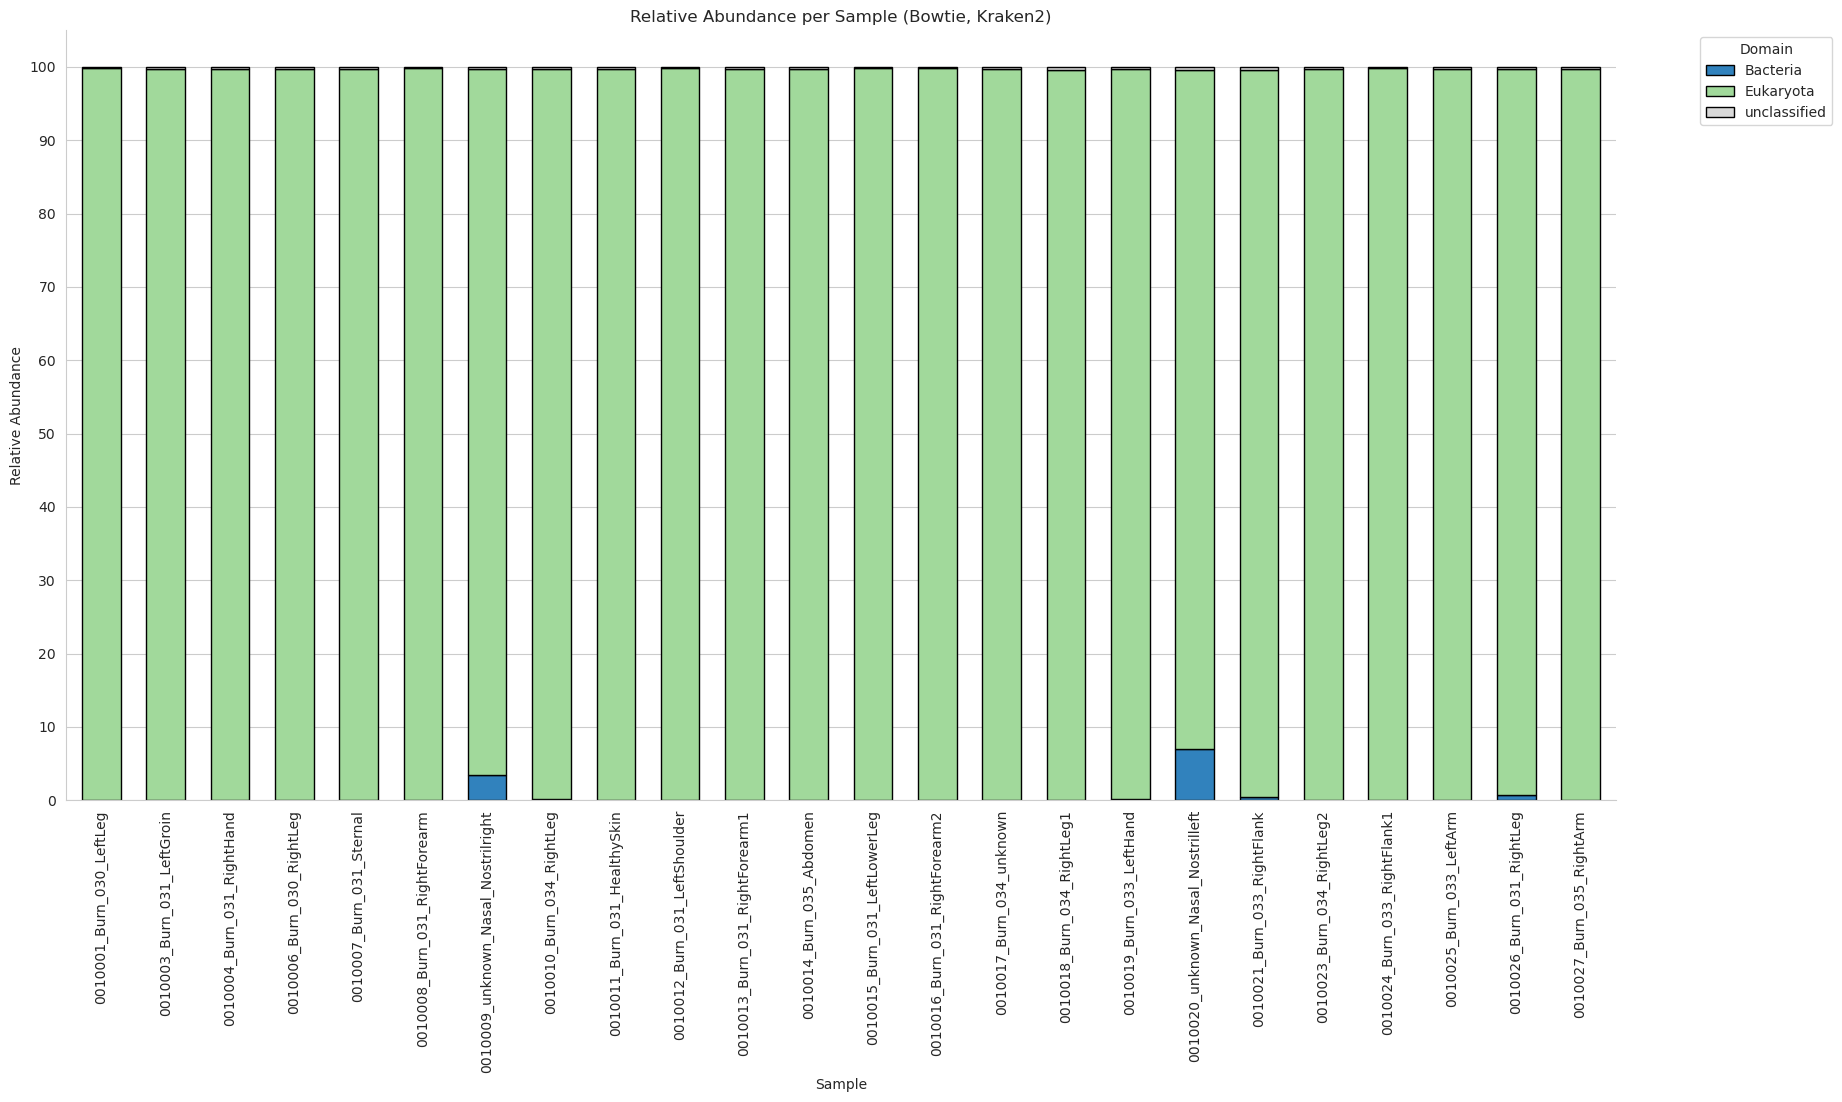

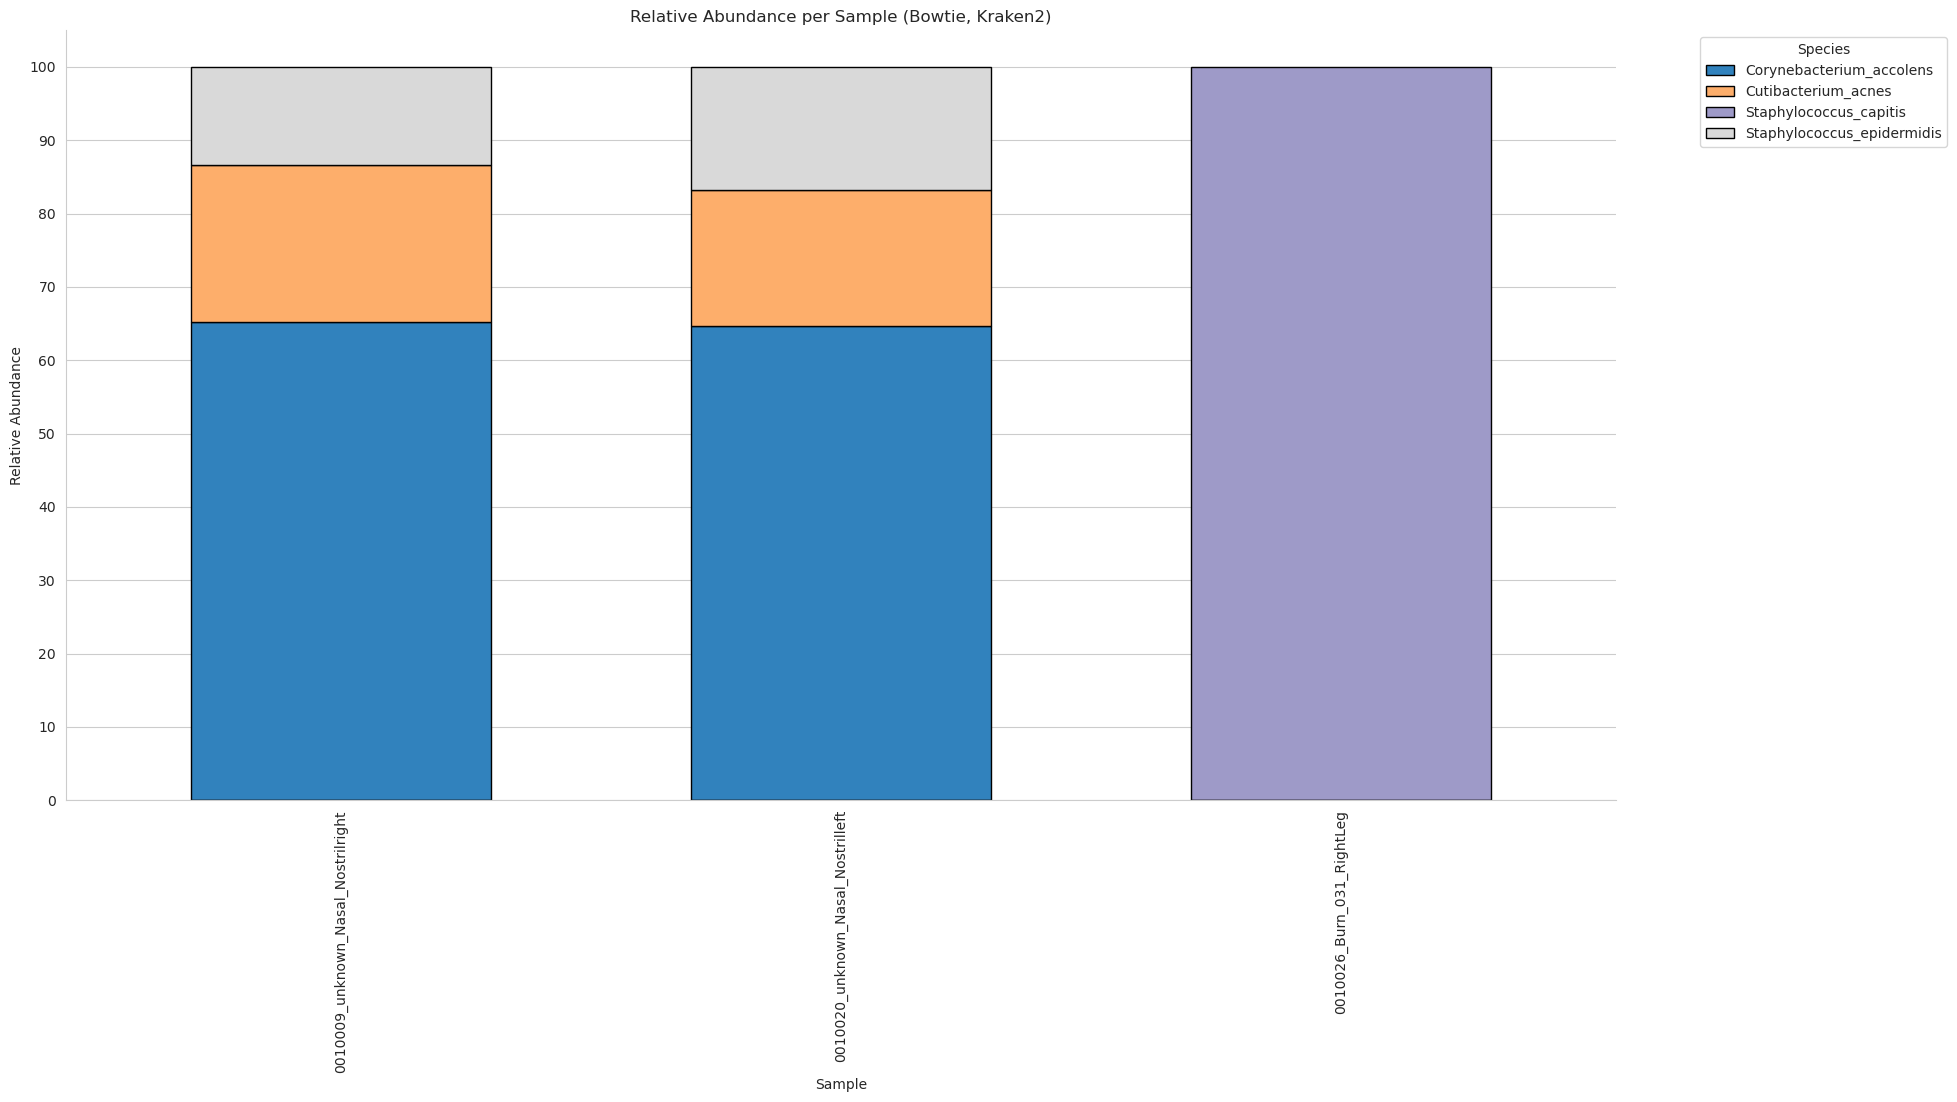

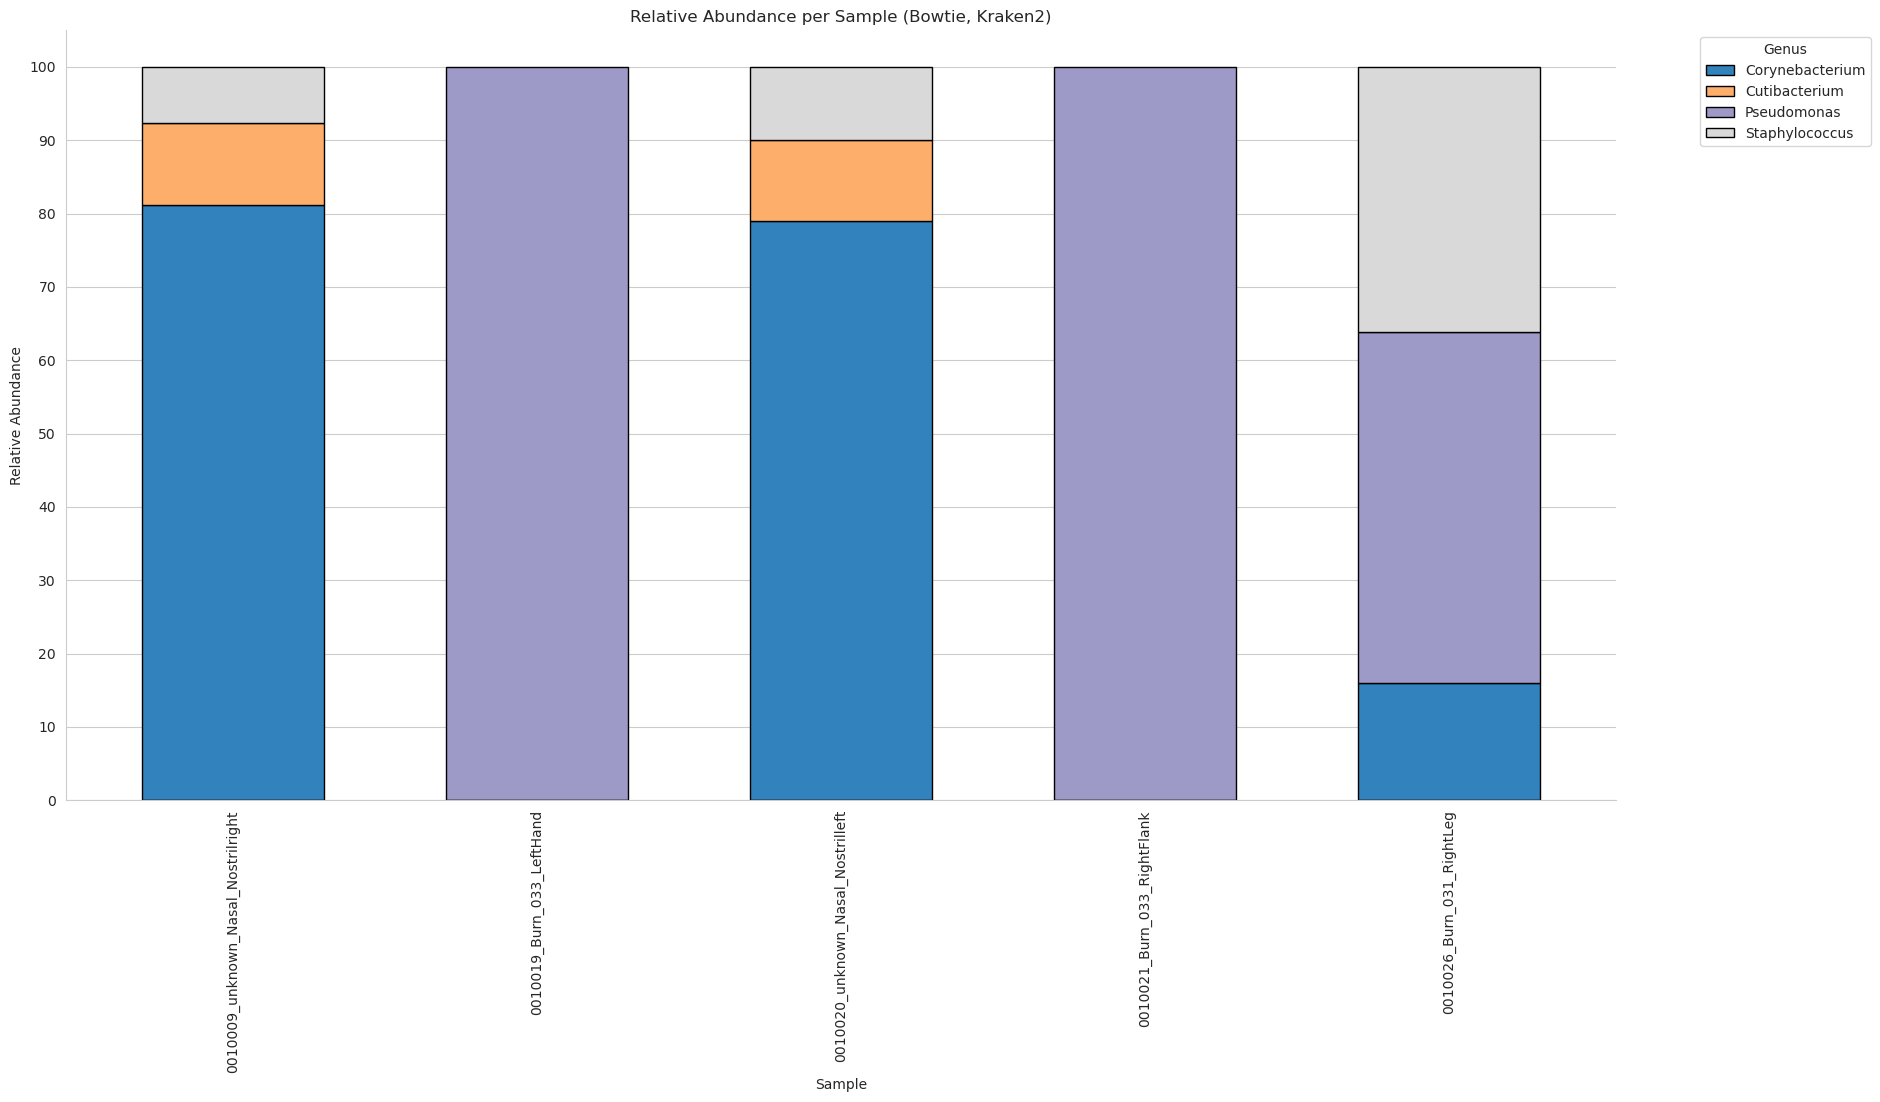

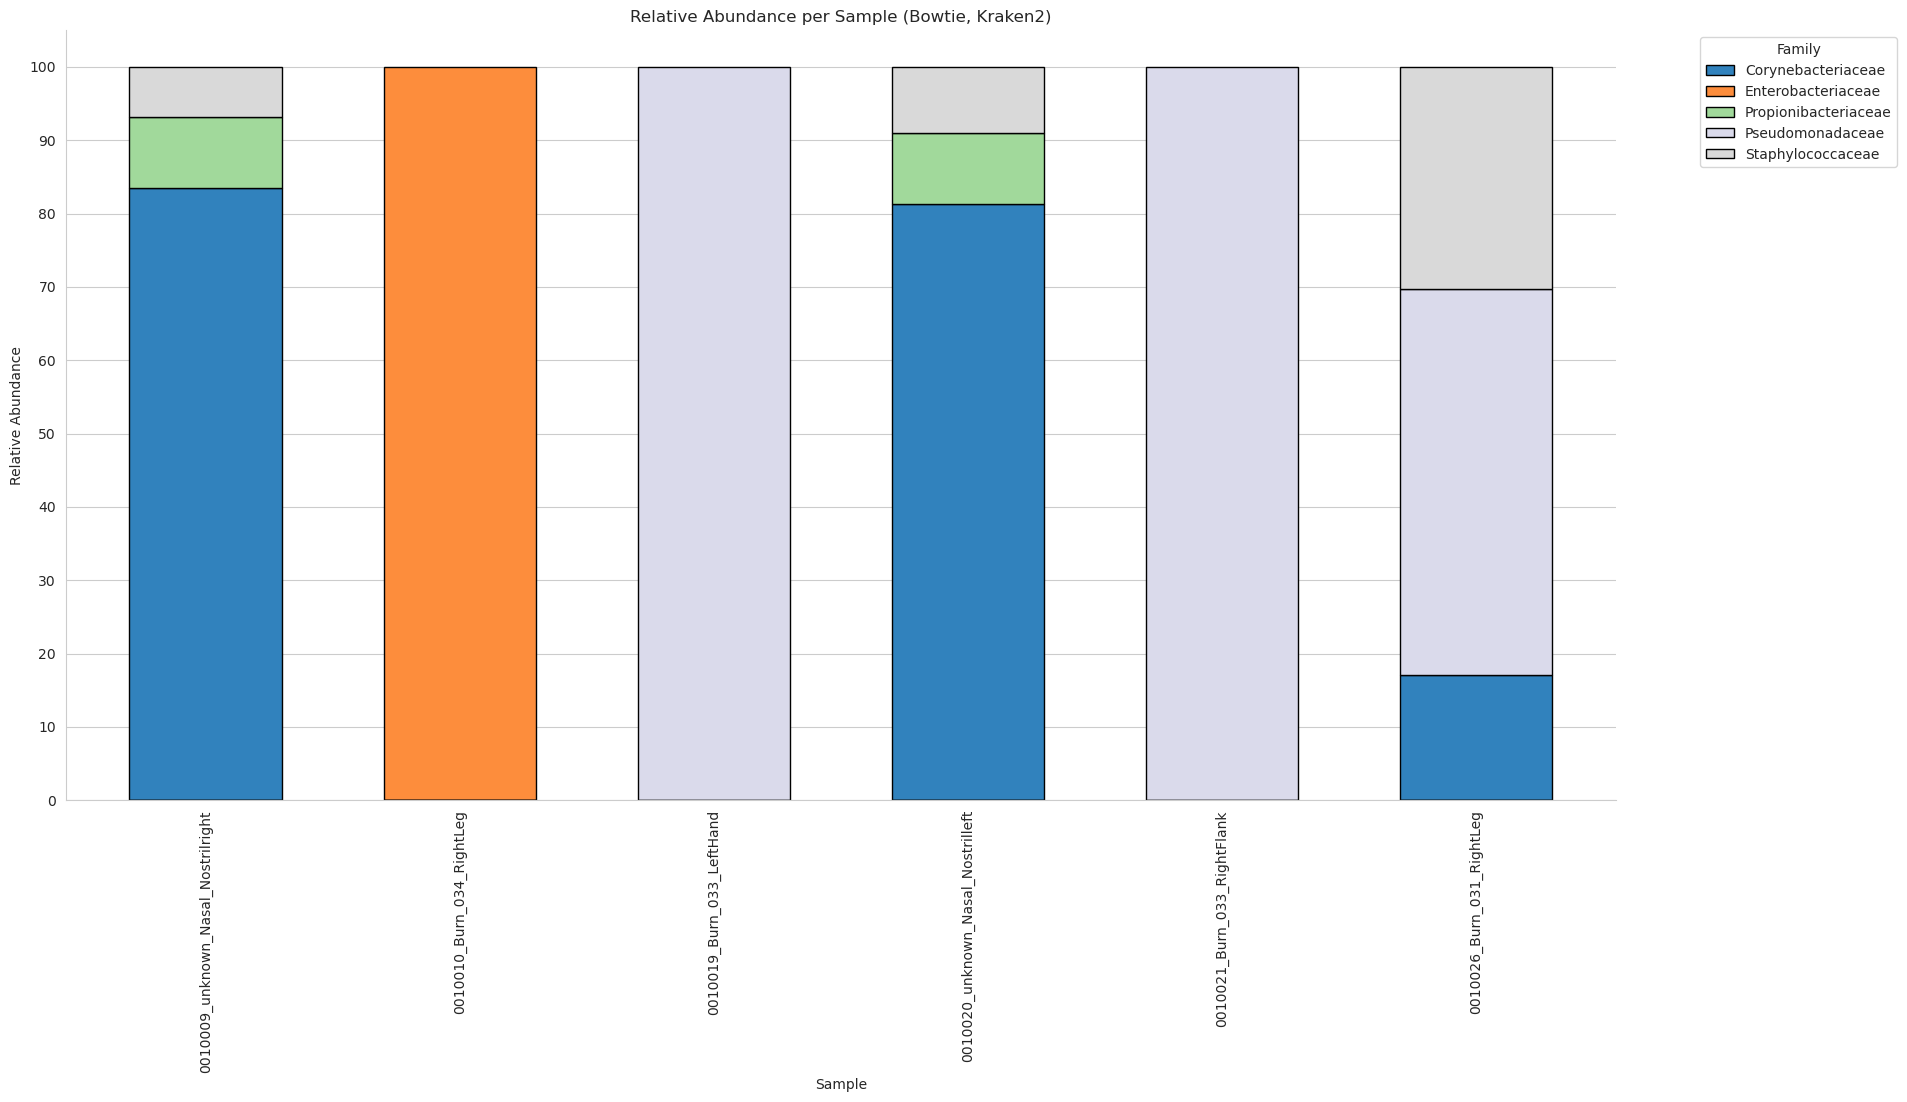

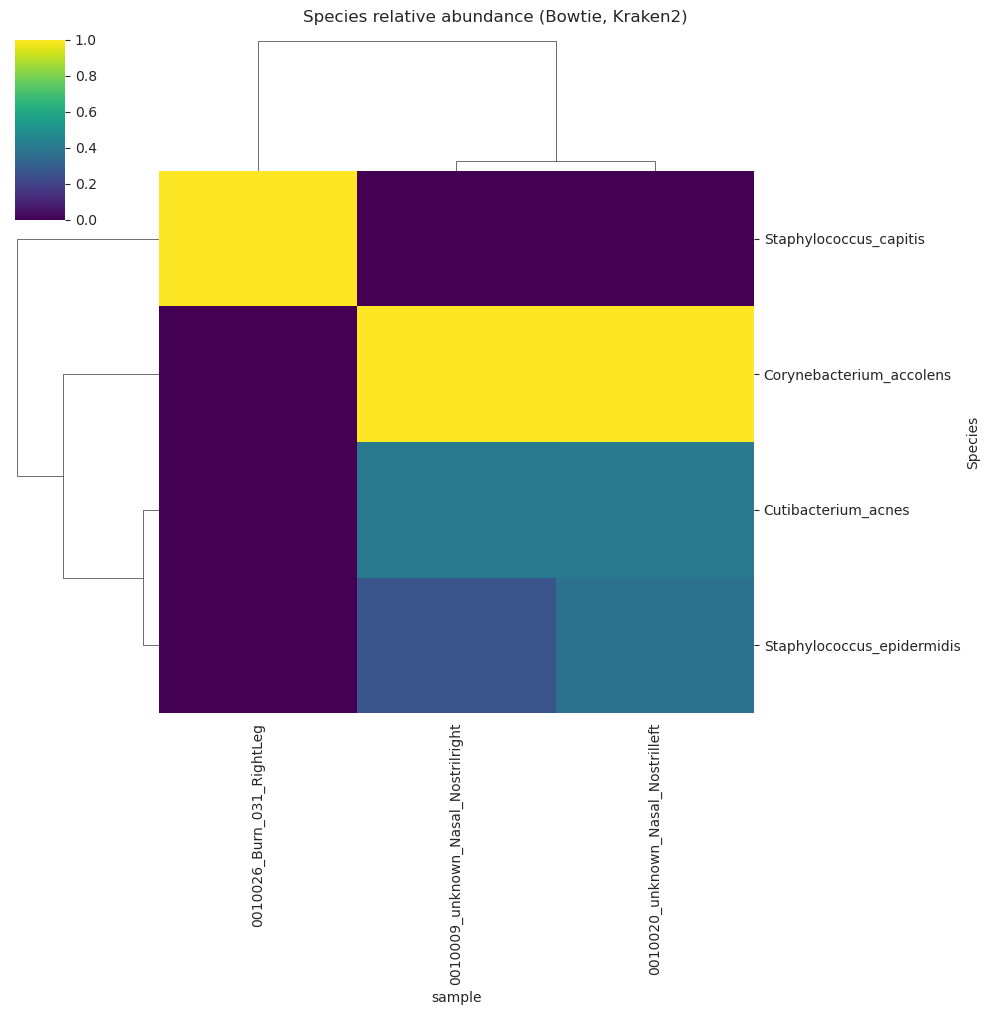

In [28]:
kraken_bowtie2_species_plot = plot_relative_abundance(kraken2_bowtie, 10, "Bowtie, Kraken2")
kraken_bowtie2_species_plot.savefig('../../results/figures/kraken2_bowtie2_domains.png', dpi=300, bbox_inches='tight')
kraken_bowtie2_species_plot = plot_relative_abundance_bacteria(kraken2_bowtie, "Species", 10, "Bowtie, Kraken2")
kraken_bowtie2_species_plot.savefig('../../results/figures/kraken2_bowtie2_species.png', dpi=300, bbox_inches='tight')
kraken_bowtie2_genus_plot = plot_relative_abundance_bacteria(kraken2_bowtie, "Genus", 10, "Bowtie, Kraken2")
kraken_bowtie2_genus_plot.savefig('../../results/figures/kraken2_bowtie2_genuses.png', dpi=300, bbox_inches='tight')
kraken_bowtie2_family_plot = plot_relative_abundance_bacteria(kraken2_bowtie, "Family", 10, "Bowtie, Kraken2")
kraken_bowtie2_family_plot.savefig('../../results/figures/kraken2_bowtie2_families.png', dpi=300, bbox_inches='tight')
kraken_bowtie2_cluster_plot = create_clustermap(kraken2_bowtie, 10, "Bowtie, Kraken2")
kraken_bowtie2_cluster_plot.savefig('../../results/figures/kraken2_bowtie2_cluster.png', dpi=300, bbox_inches='tight')

### BBmap

/tmp/ipykernel_1087/137330775.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed 

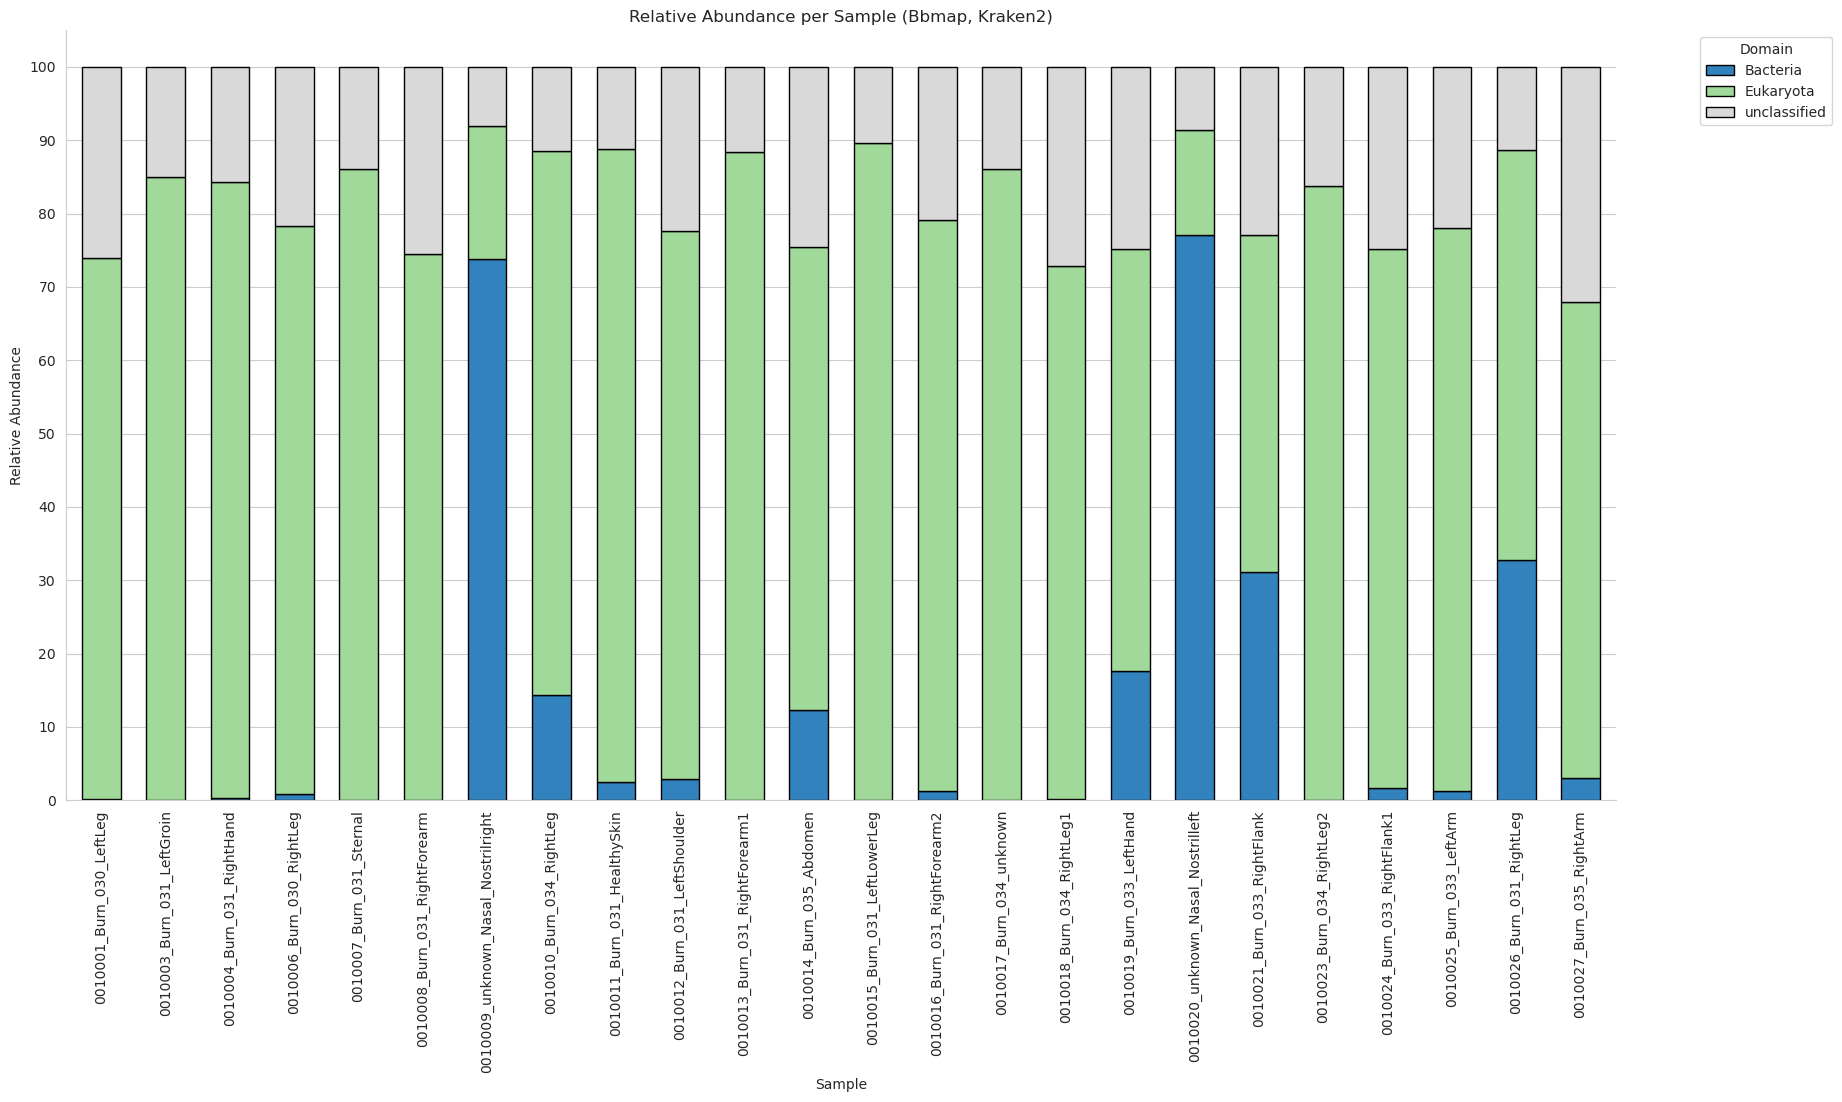

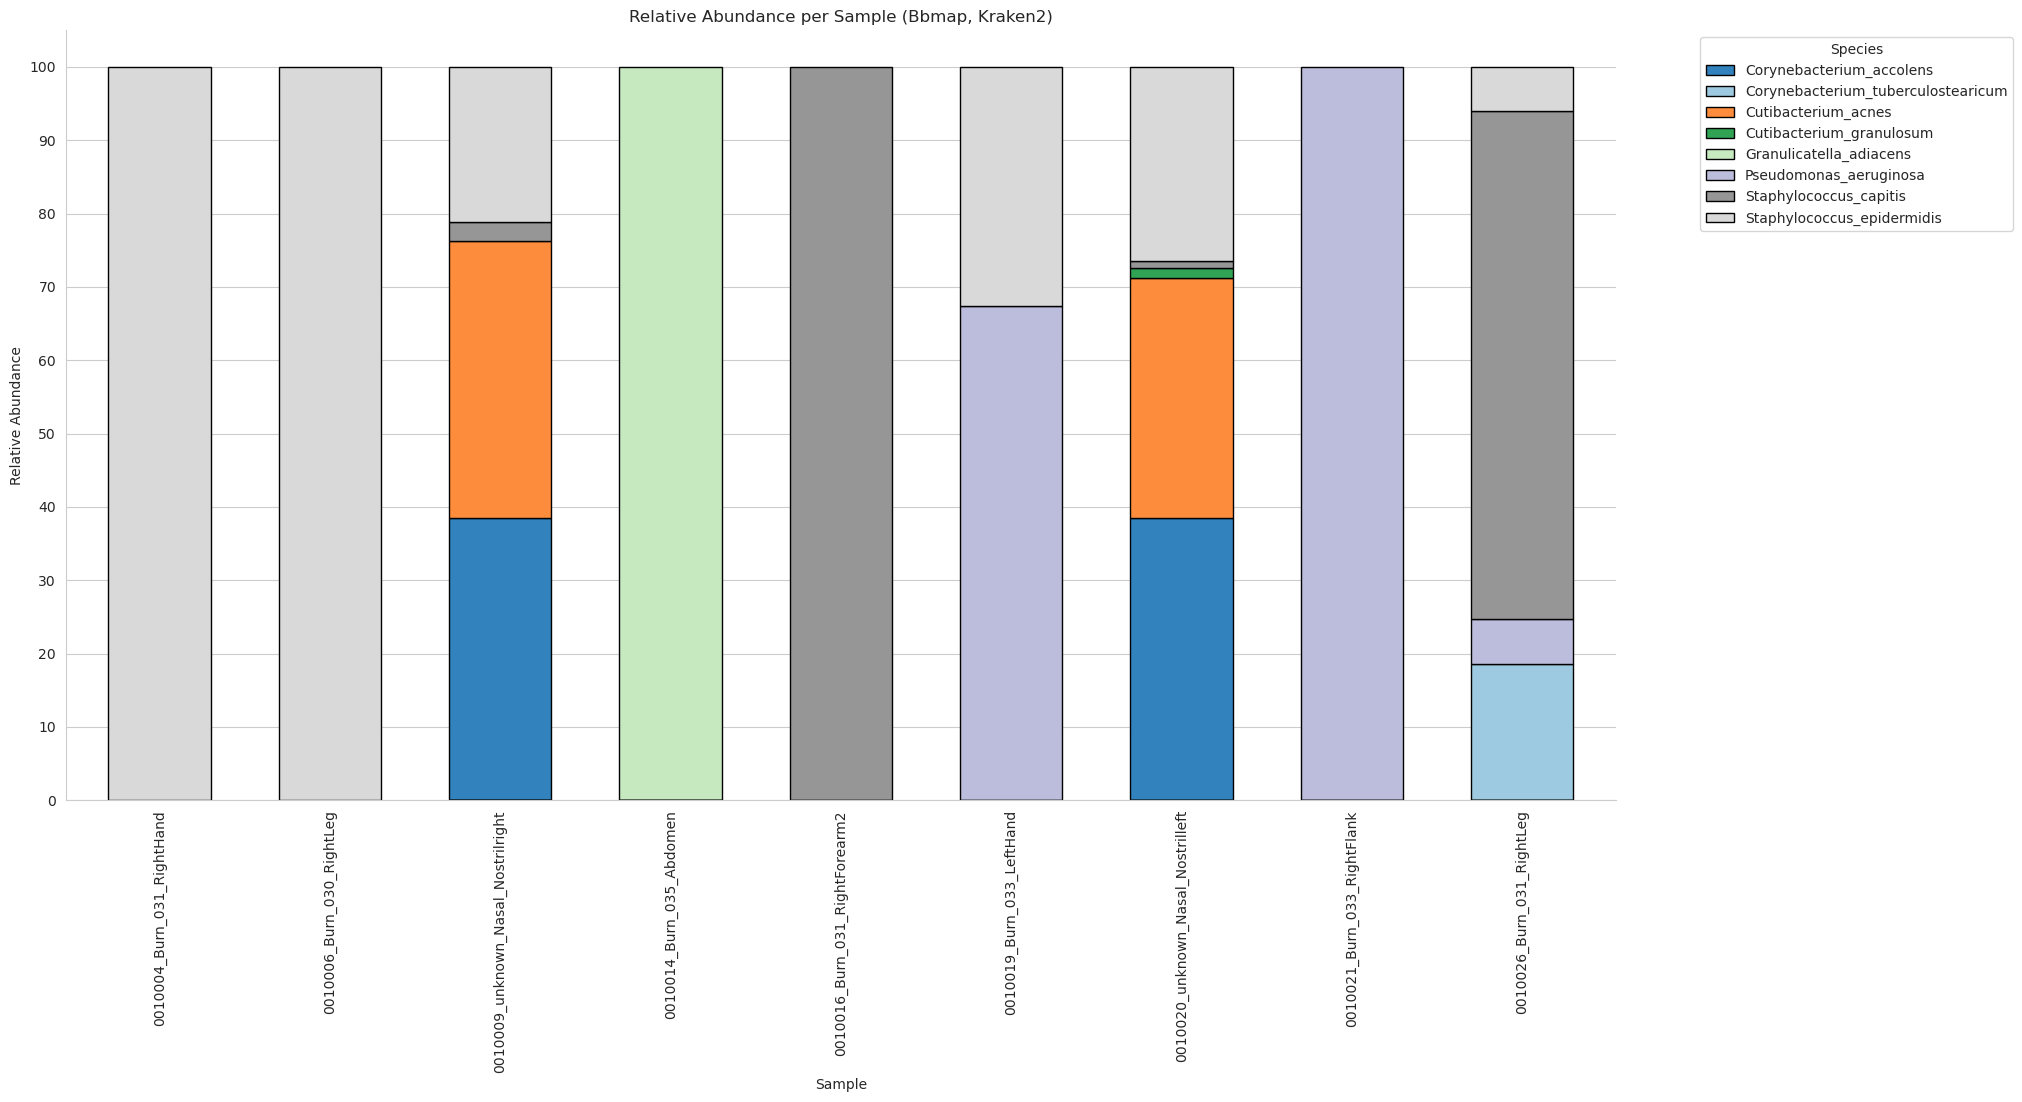

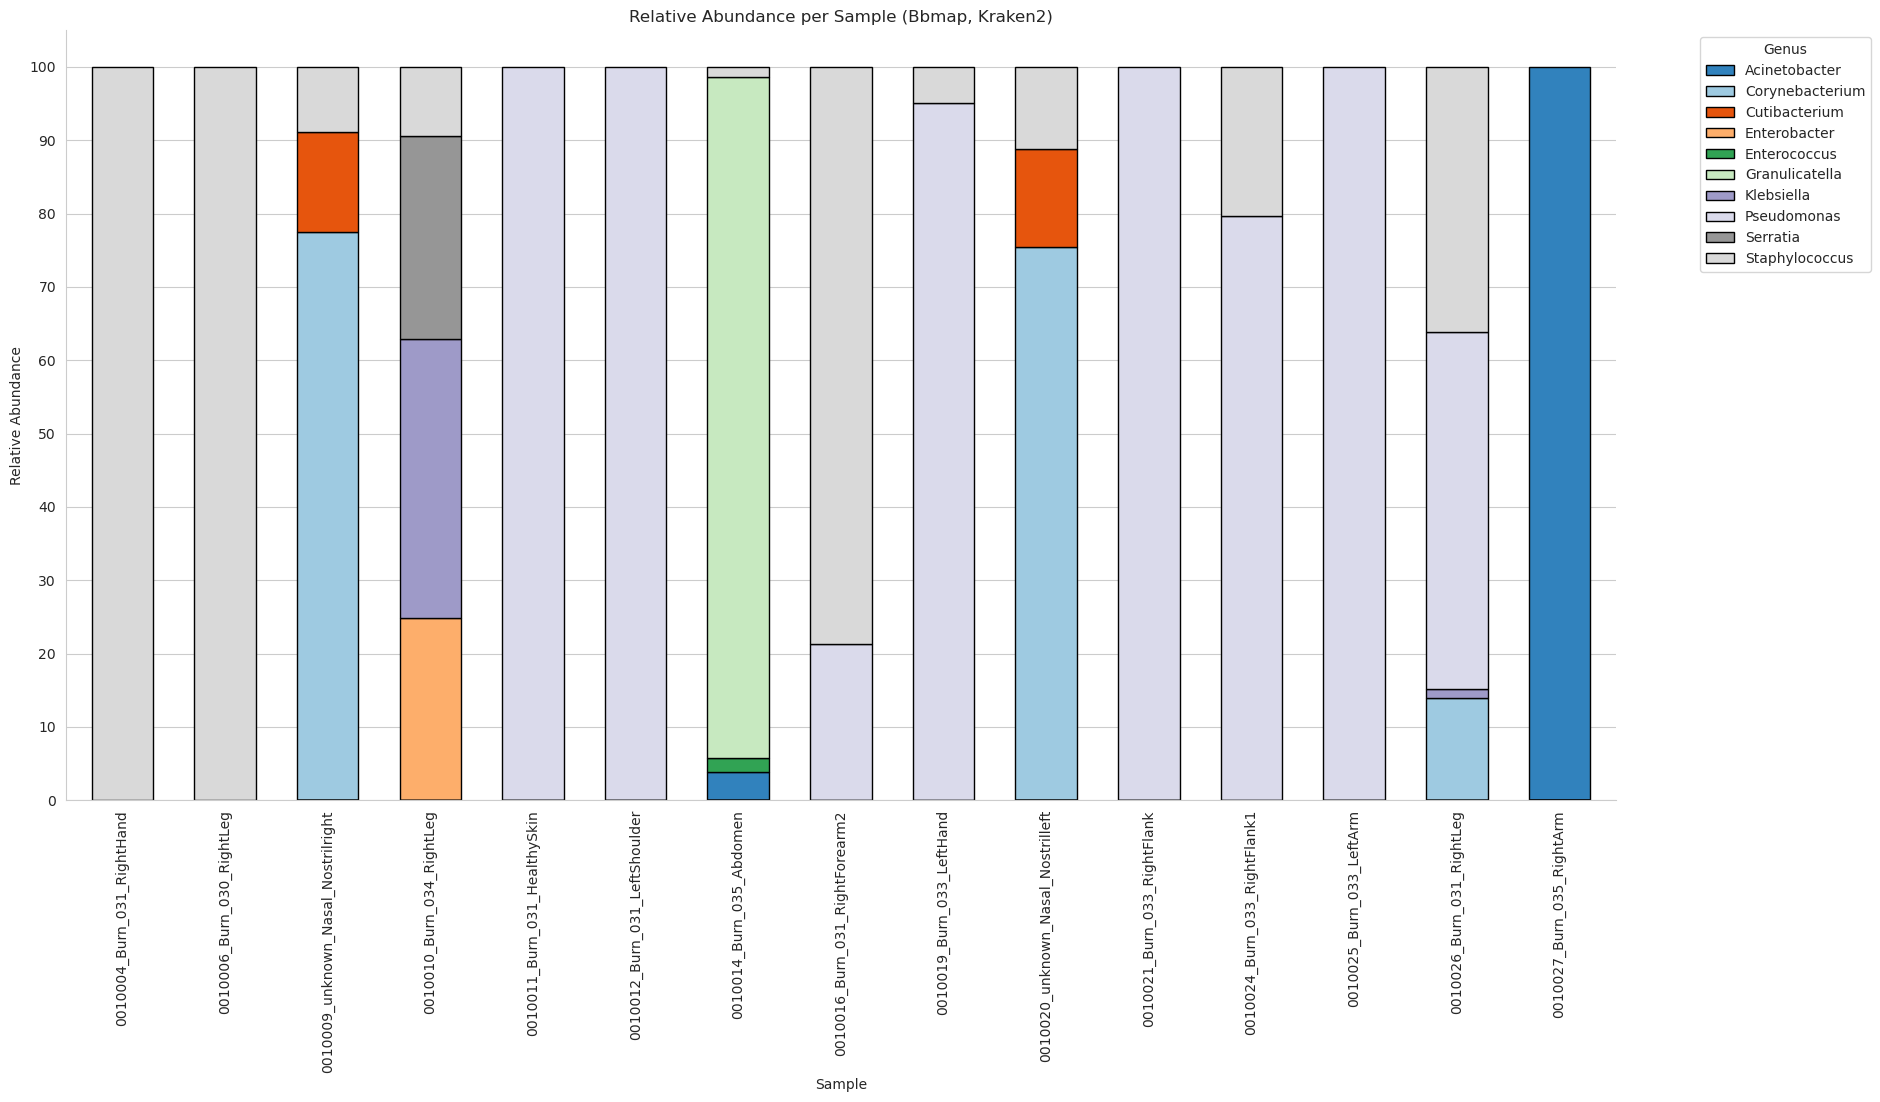

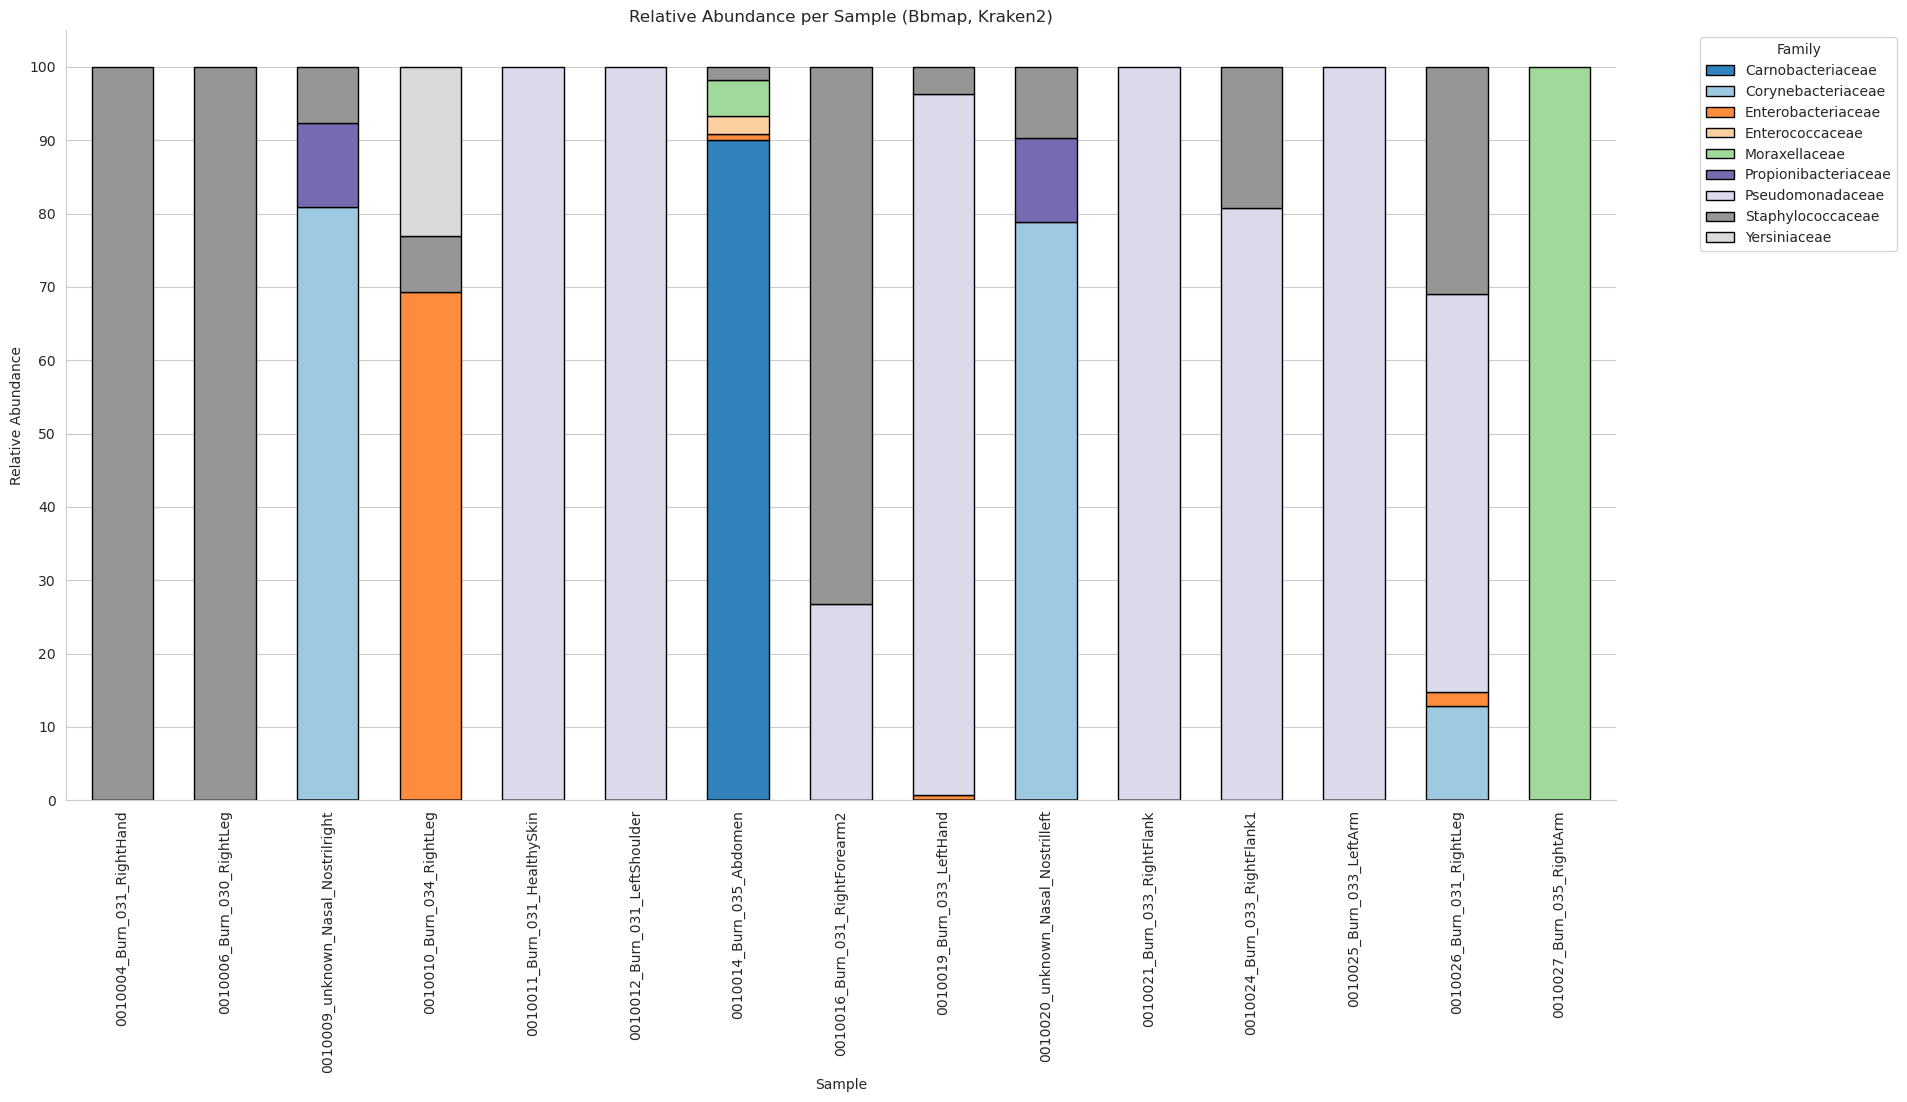

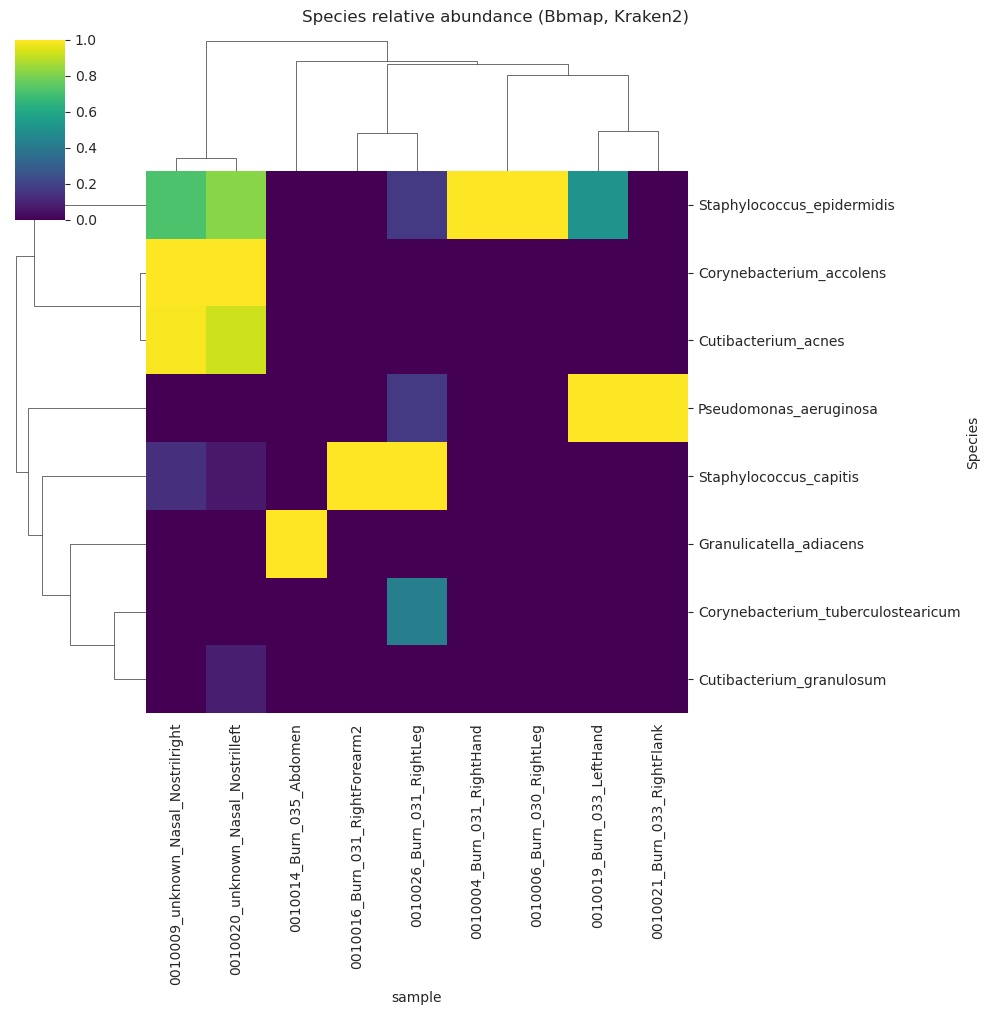

In [29]:
kraken_bbmap_species_plot = plot_relative_abundance(kraken2_bbmap, 10, "Bbmap, Kraken2")
kraken_bbmap_species_plot.savefig('../../results/figures/kraken2_bbmap_domains.png', dpi=300, bbox_inches='tight')
kraken_bbmap_species_plot = plot_relative_abundance_bacteria(kraken2_bbmap, "Species",  10, "Bbmap, Kraken2")
kraken_bbmap_species_plot.savefig('../../results/figures/kraken2_bbmap_species.png', dpi=300, bbox_inches='tight')
kraken_bbmap_species_plot = plot_relative_abundance_bacteria(kraken2_bbmap, "Genus", 10, "Bbmap, Kraken2")
kraken_bbmap_species_plot.savefig('../../results/figures/kraken2_bbmap_genuses.png', dpi=300, bbox_inches='tight')
kraken_bbmap_species_plot = plot_relative_abundance_bacteria(kraken2_bbmap, "Family", 10, "Bbmap, Kraken2")
kraken_bbmap_species_plot.savefig('../../results/figures/kraken2_bbmap_families.png', dpi=300, bbox_inches='tight')
kraken_bbmap_cluster_plot = create_clustermap(kraken2_bbmap, 10, "Bbmap, Kraken2")
kraken_bbmap_cluster_plot.savefig('../../results/figures/kraken2_bbmap_cluster.png', dpi=300, bbox_inches='tight')

## MetaPhlAn4

### Bowtie

/tmp/ipykernel_1087/137330775.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed 

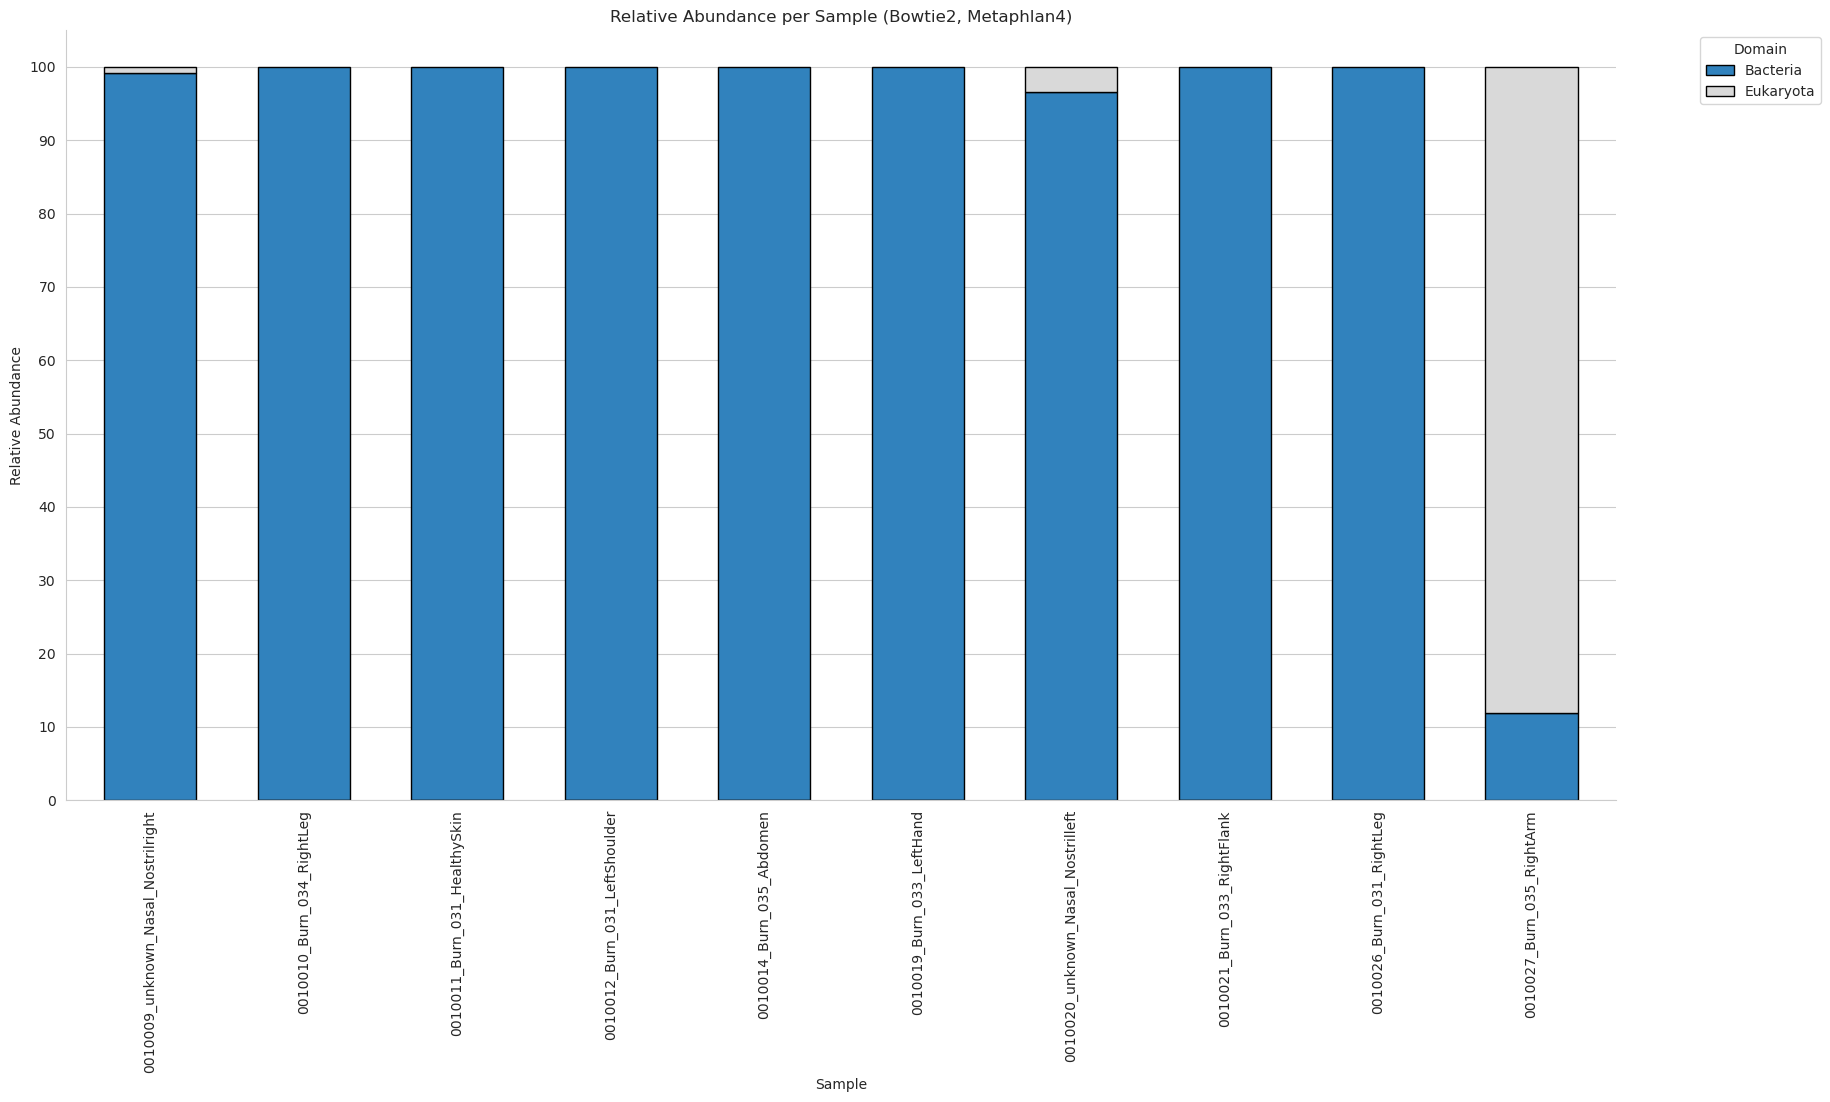

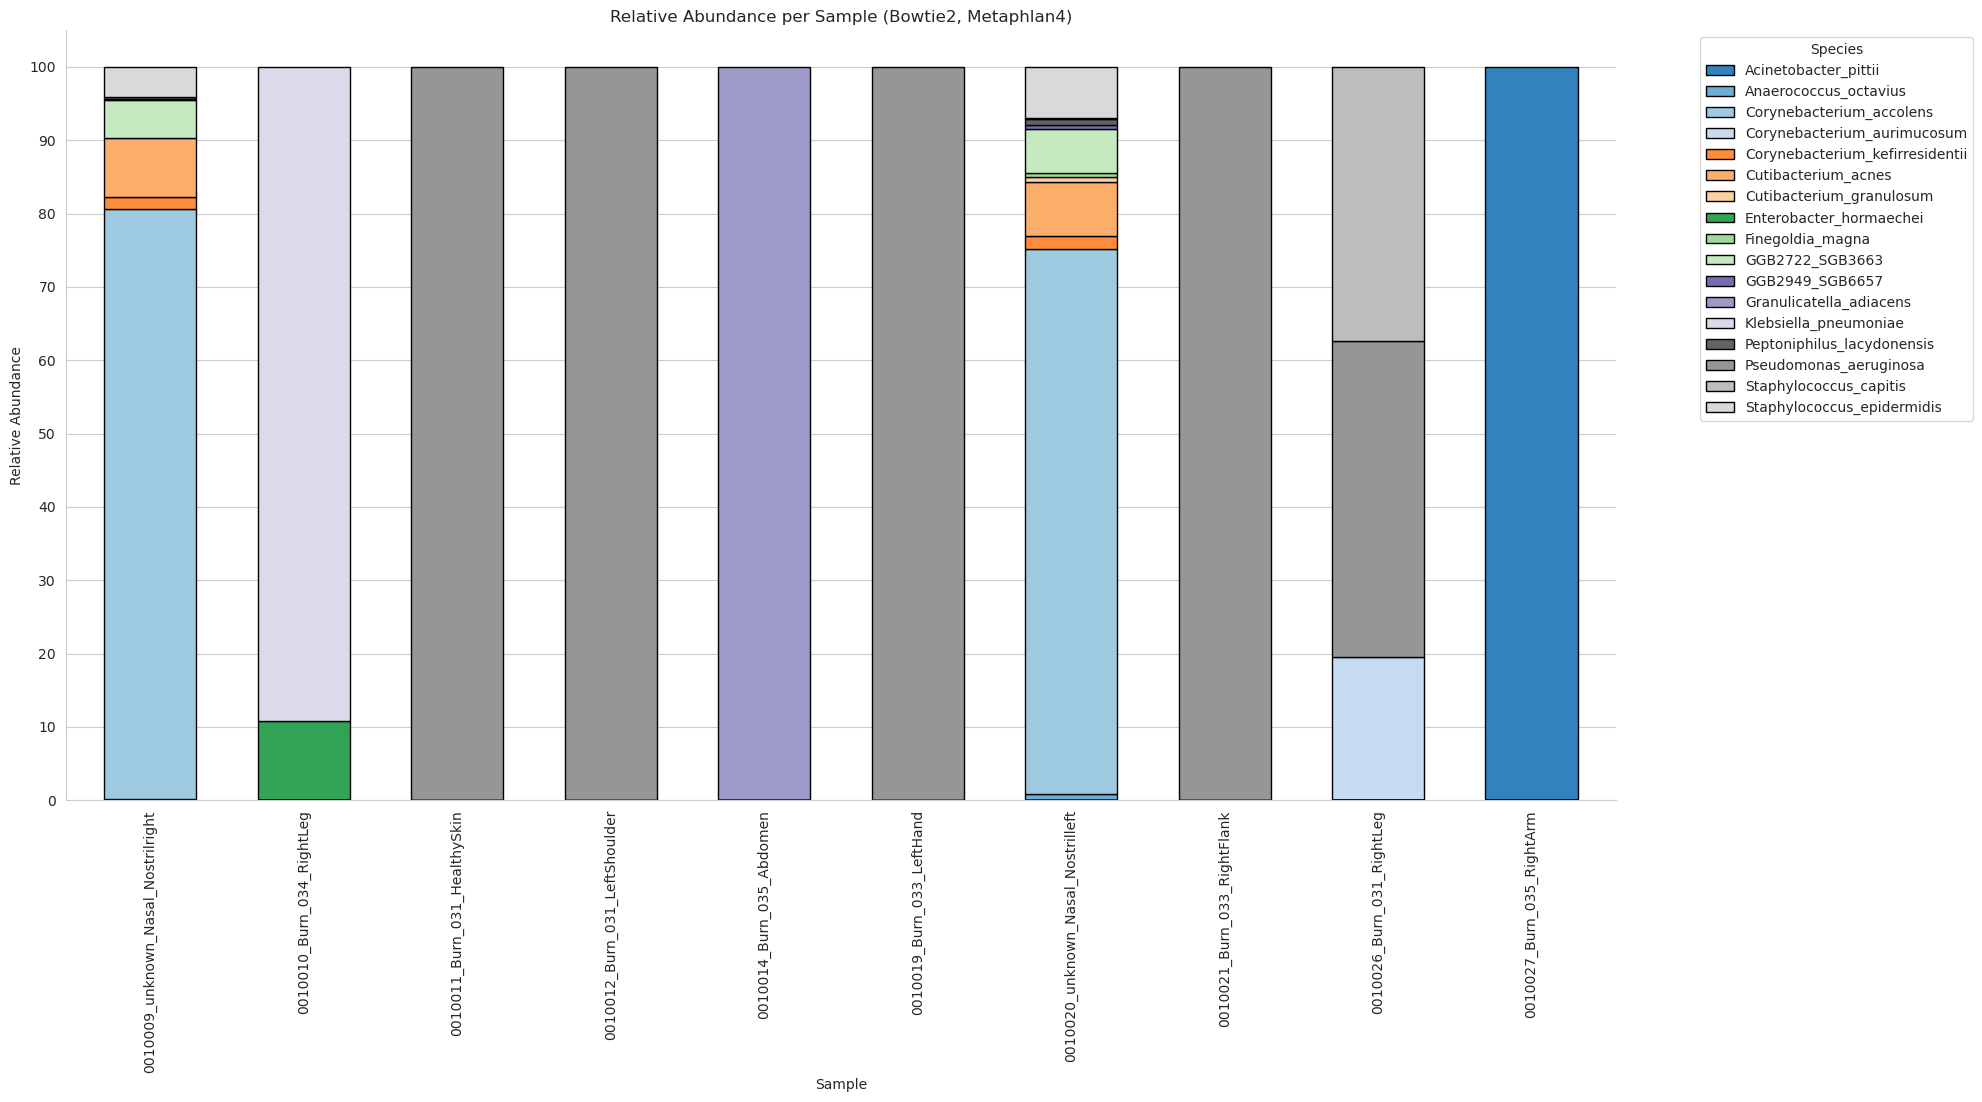

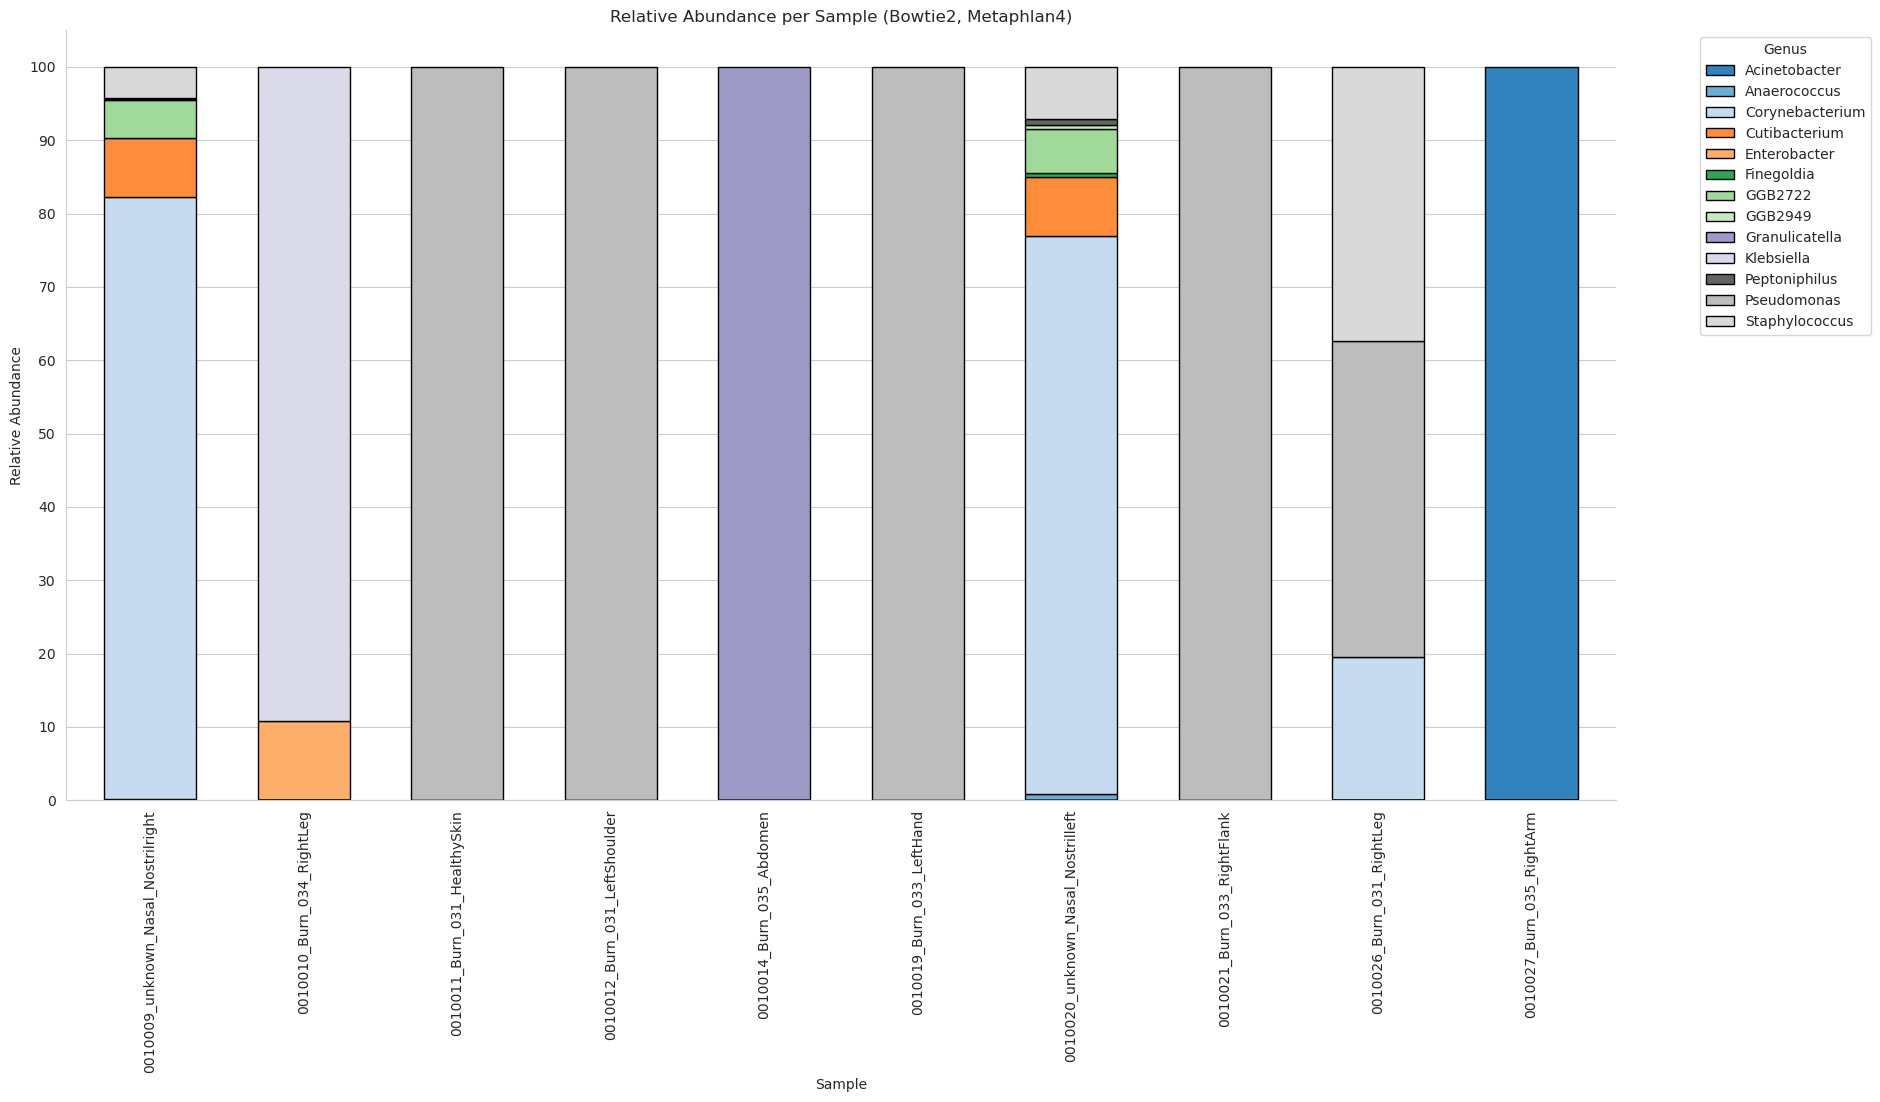

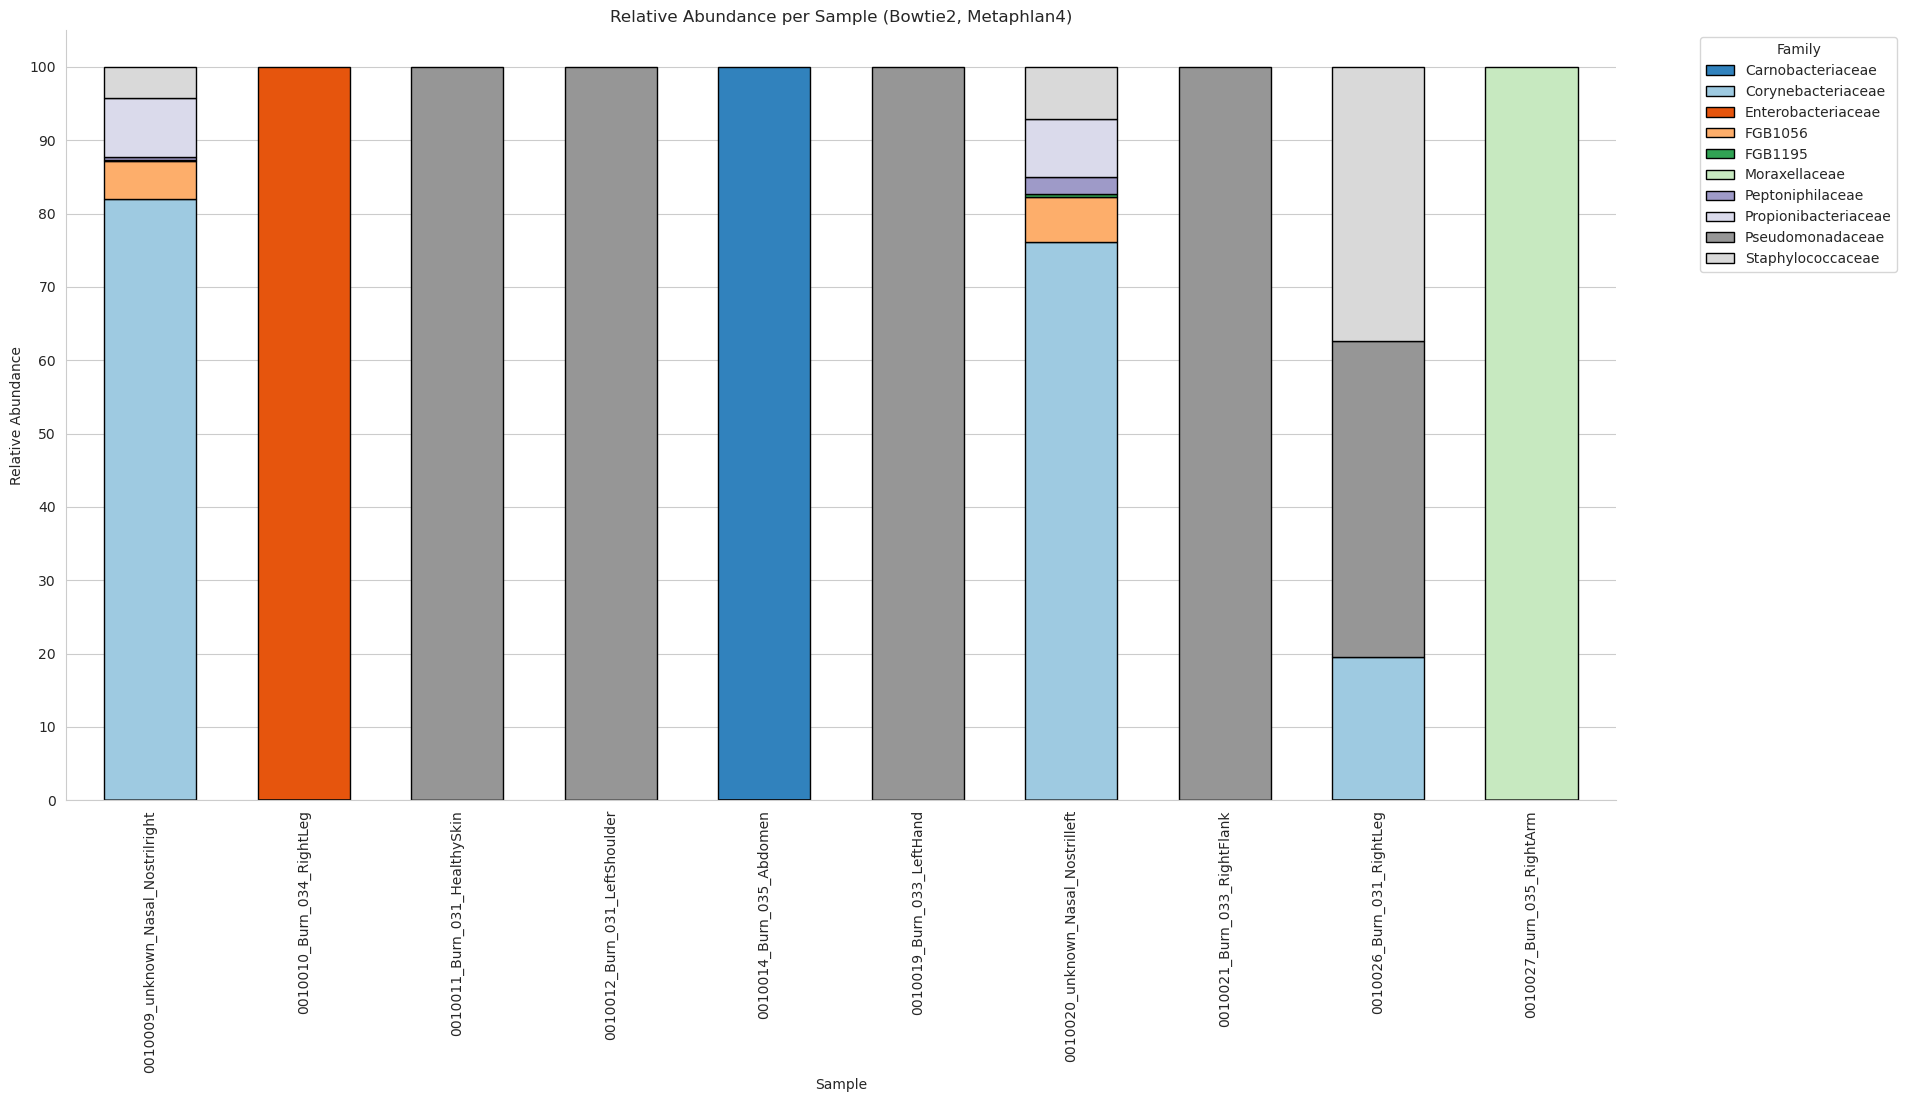

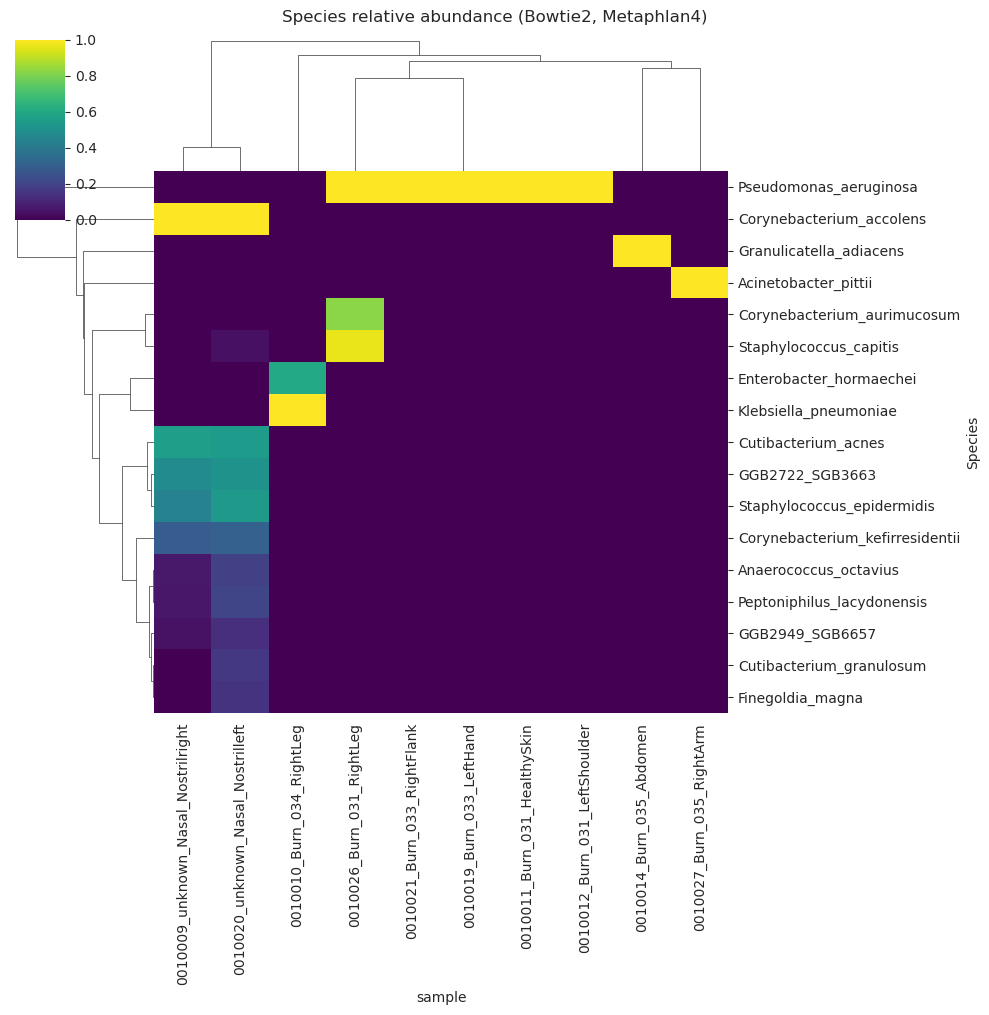

In [30]:
metaphlan4_bowtie2_species_plot = plot_relative_abundance(metaphlan_bowtie, 10, "Bowtie2, Metaphlan4")
metaphlan4_bowtie2_species_plot.savefig('../../results/figures/metaphlan4_bowtie2_domains.png', dpi=300, bbox_inches='tight')
metaphlan4_bowtie2_species_plot = plot_relative_abundance_bacteria(metaphlan_bowtie, "Species", 10, "Bowtie2, Metaphlan4")
metaphlan4_bowtie2_species_plot.savefig('../../results/figures/metaphlan4_bowtie2_speciess.png', dpi=300, bbox_inches='tight')
metaphlan4_bowtie2_species_plot = plot_relative_abundance_bacteria(metaphlan_bowtie,  "Genus", 10, "Bowtie2, Metaphlan4")
metaphlan4_bowtie2_species_plot.savefig('../../results/figures/metaphlan4_bowtie2_genuses.png', dpi=300, bbox_inches='tight')
metaphlan4_bowtie2_species_plot = plot_relative_abundance_bacteria(metaphlan_bowtie, "Family", 10, "Bowtie2, Metaphlan4")
metaphlan4_bowtie2_species_plot.savefig('../../results/figures/metaphlan4_bowtie2_families.png', dpi=300, bbox_inches='tight')
metaphlan_bowtie2_cluster_plot = create_clustermap(metaphlan_bowtie, 10, "Bowtie2, Metaphlan4")
metaphlan_bowtie2_cluster_plot.savefig('../../results/figures/metaphlan4_bowtie2_cluster.png', dpi=300, bbox_inches='tight')

### BBMap

/tmp/ipykernel_1087/137330775.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/1050064477.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed 

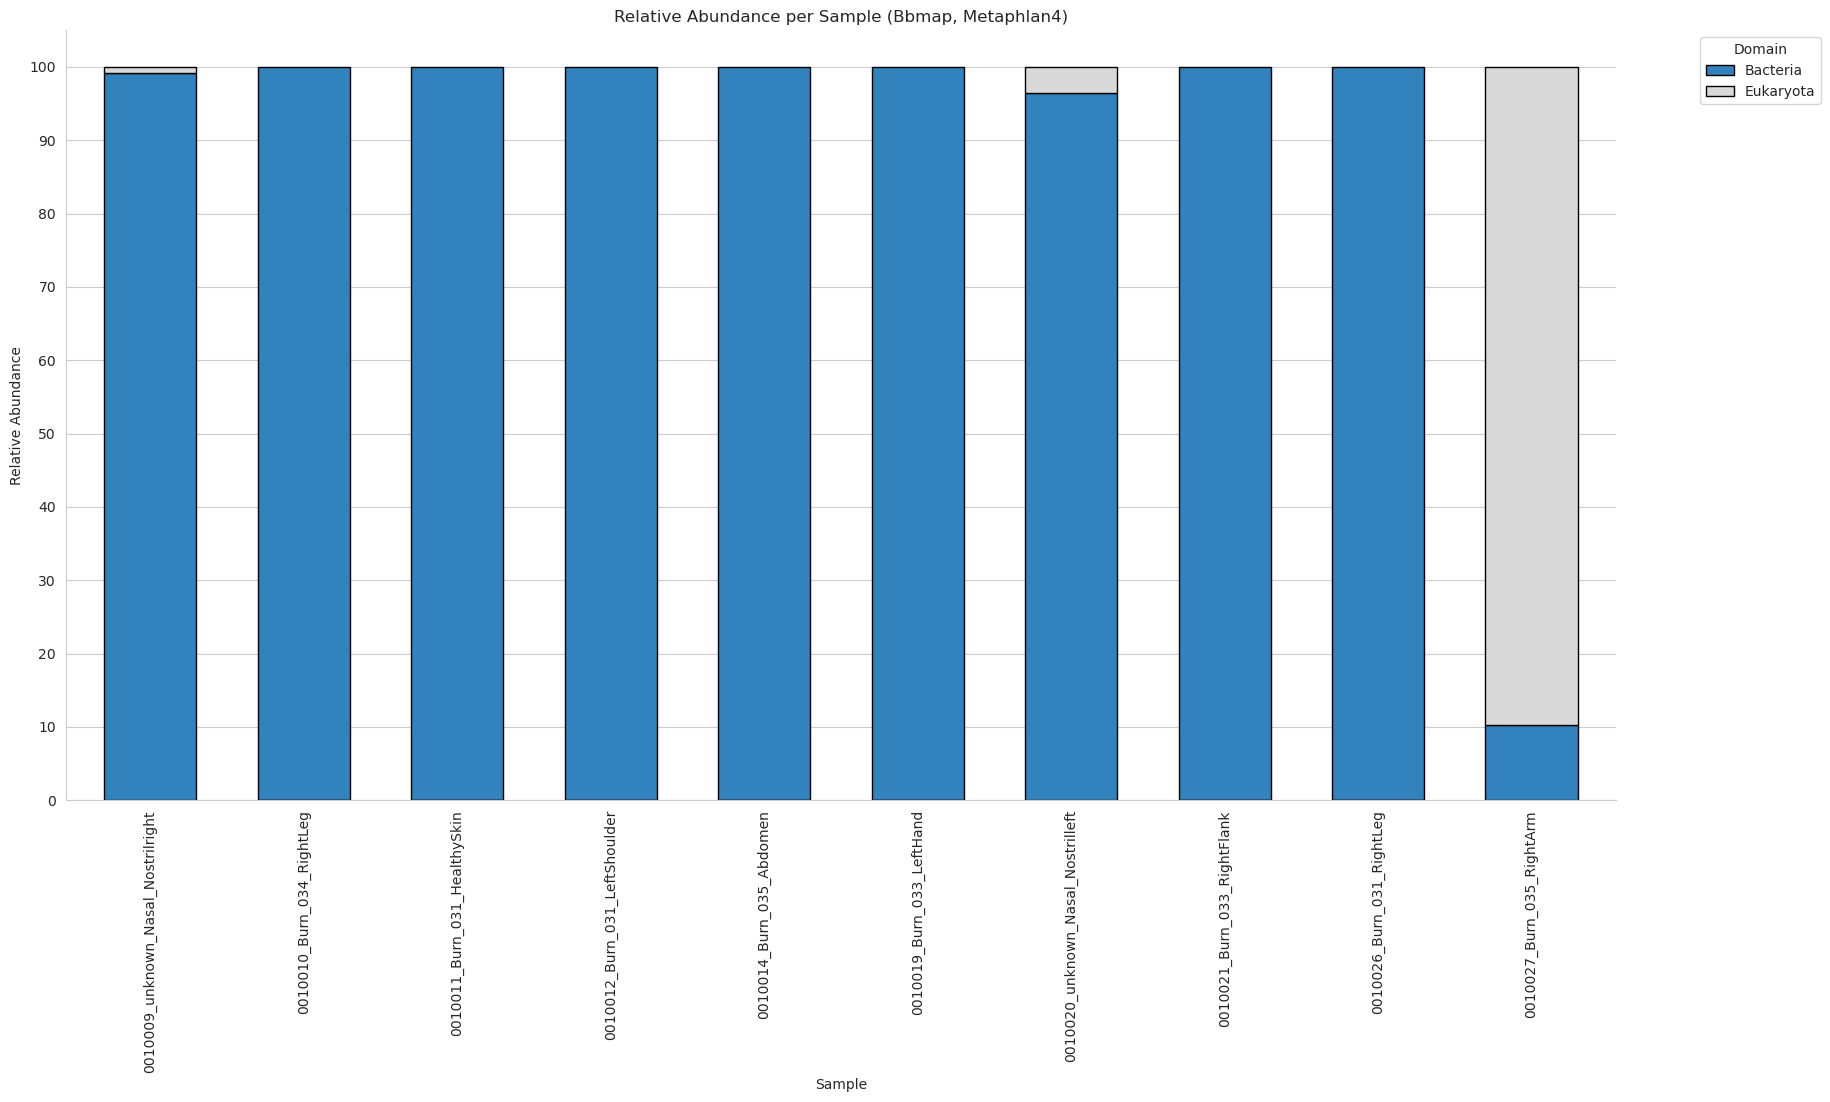

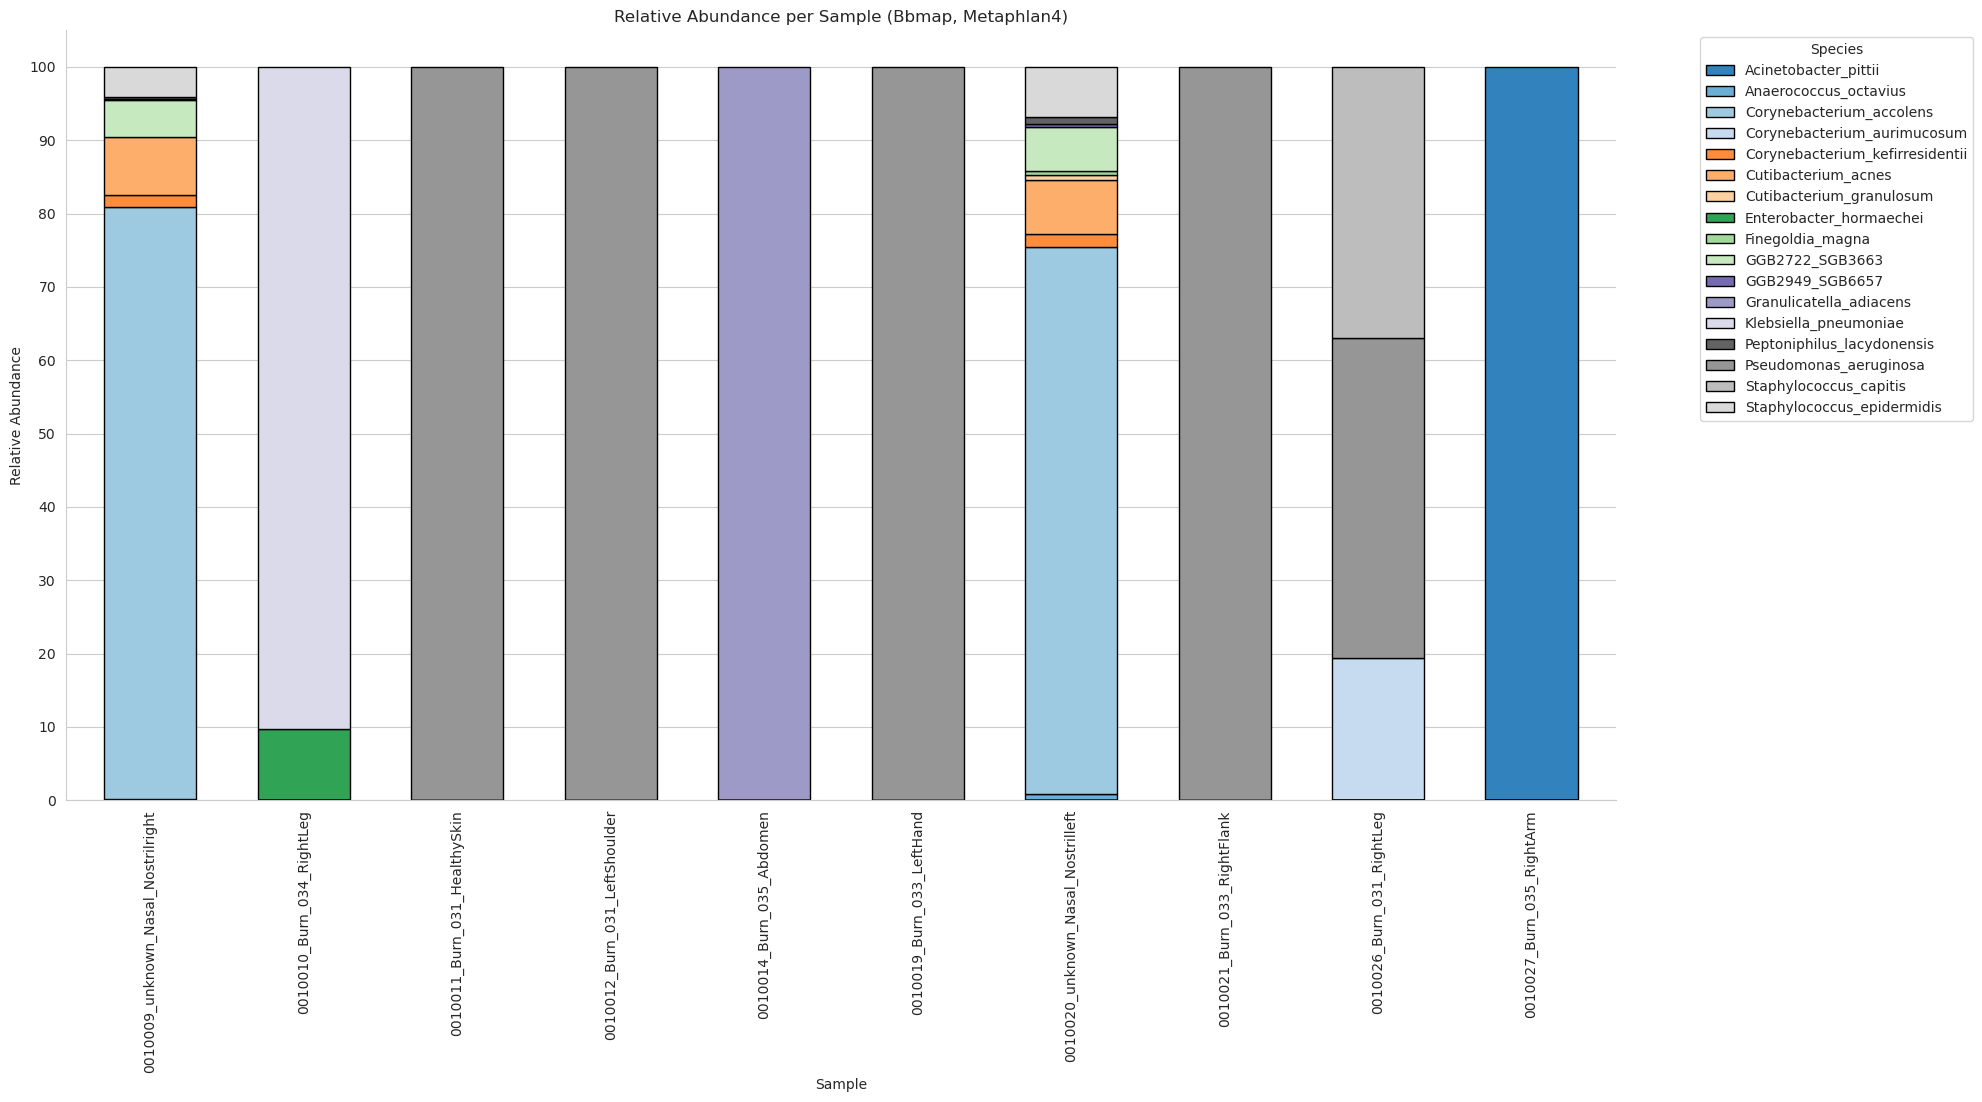

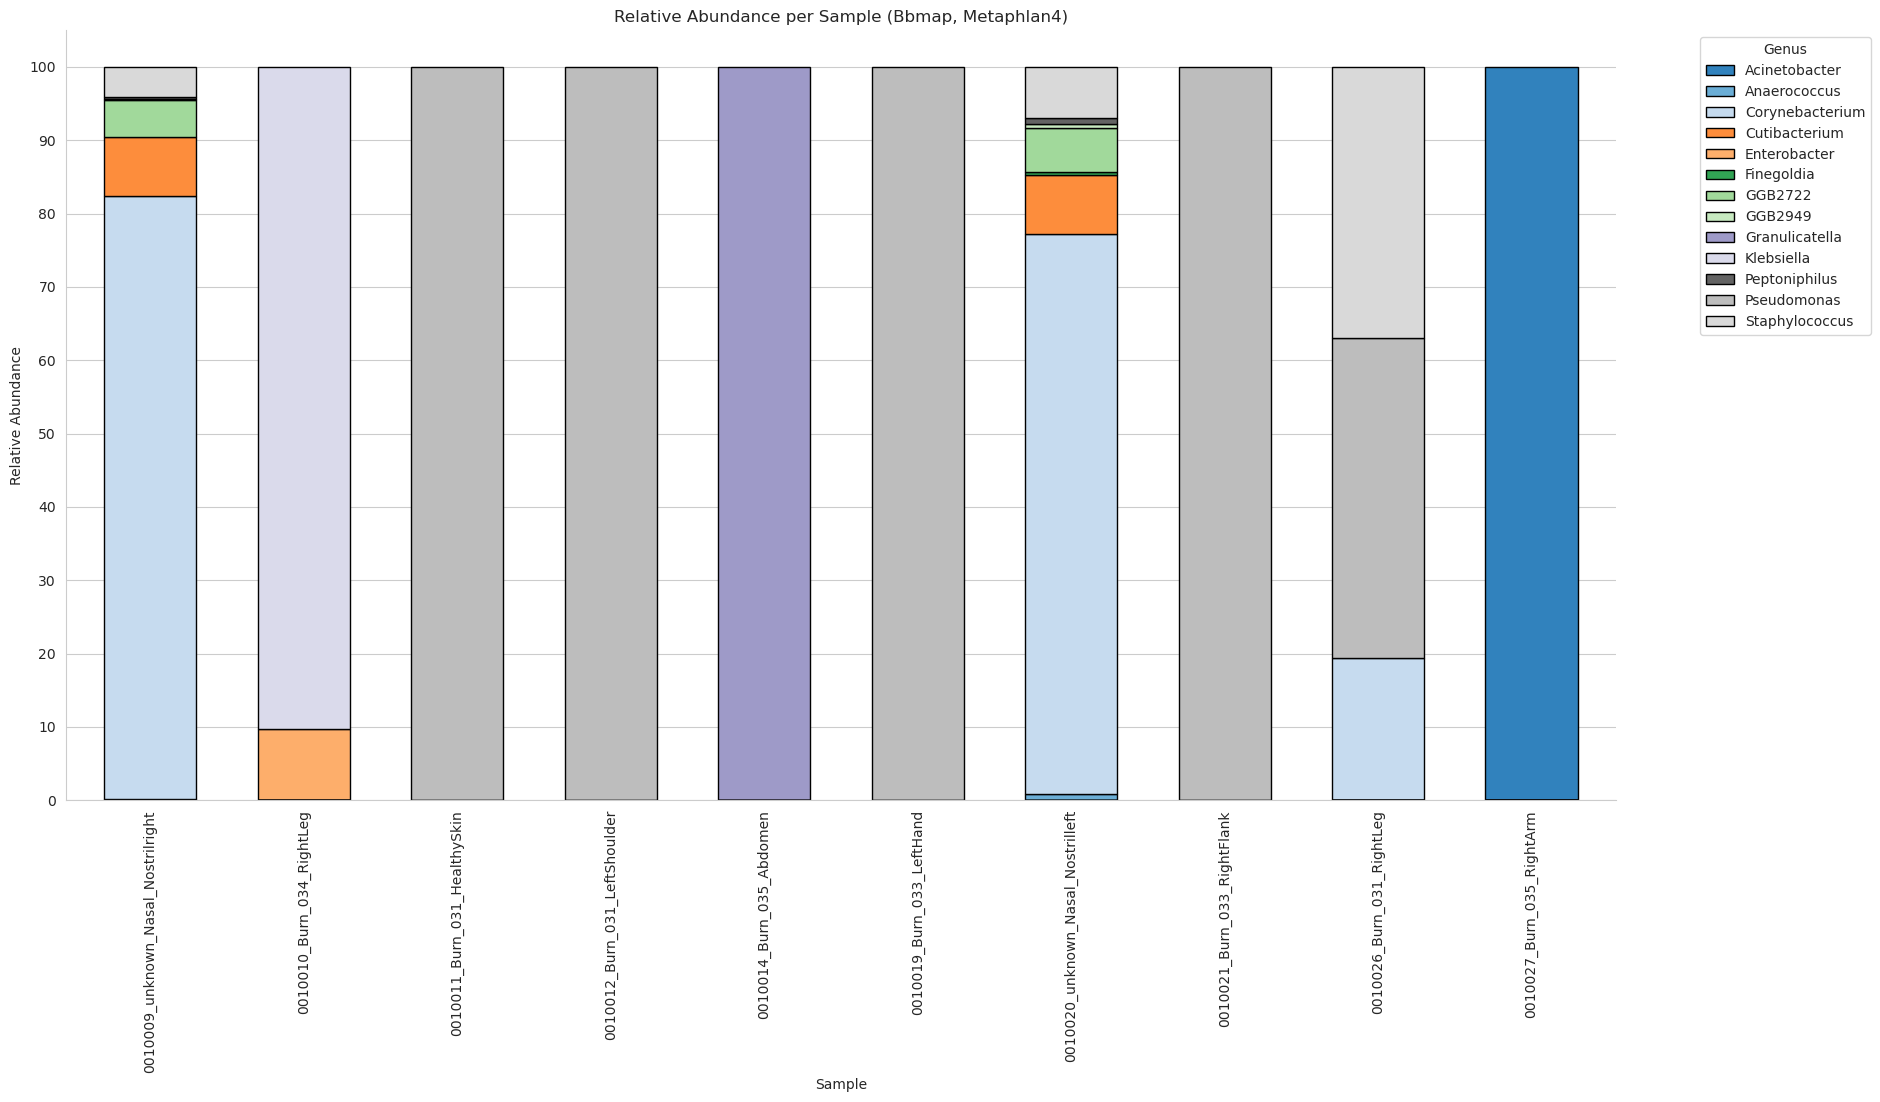

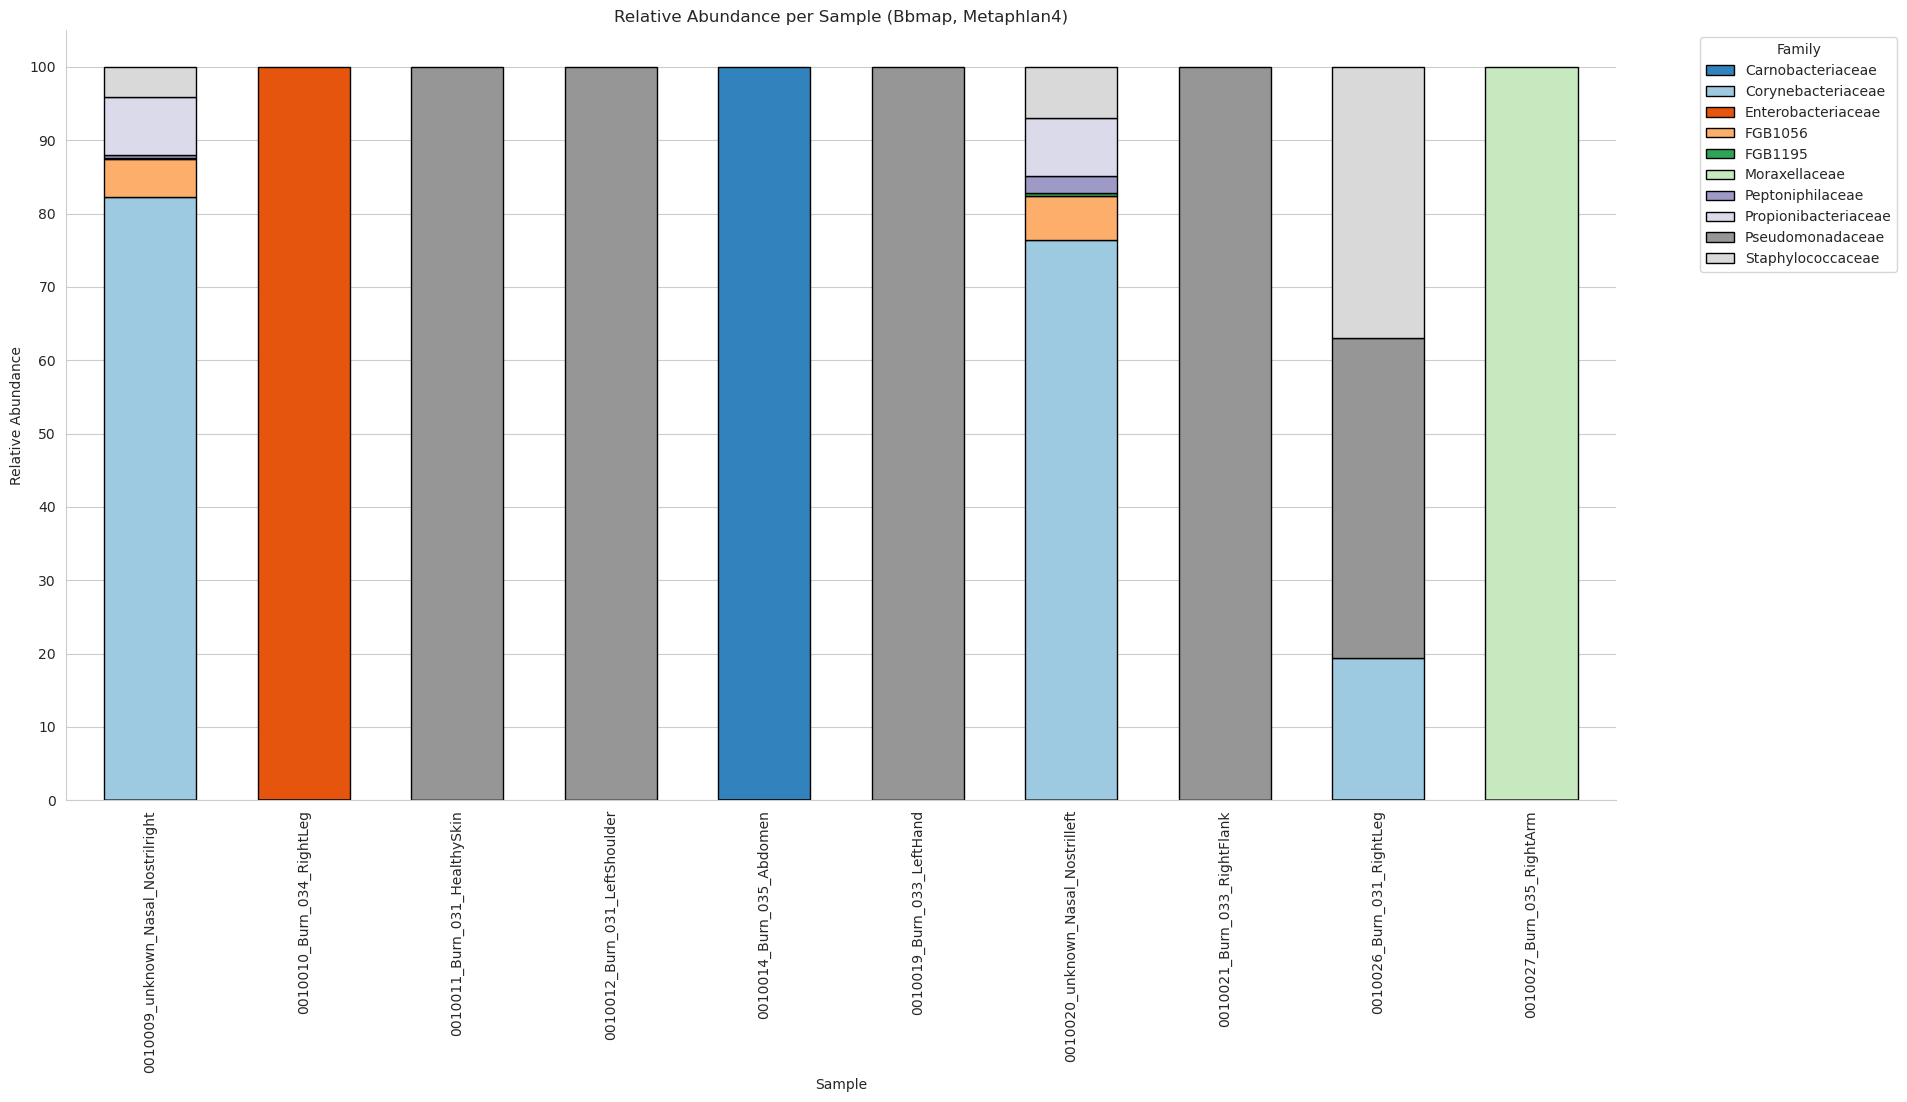

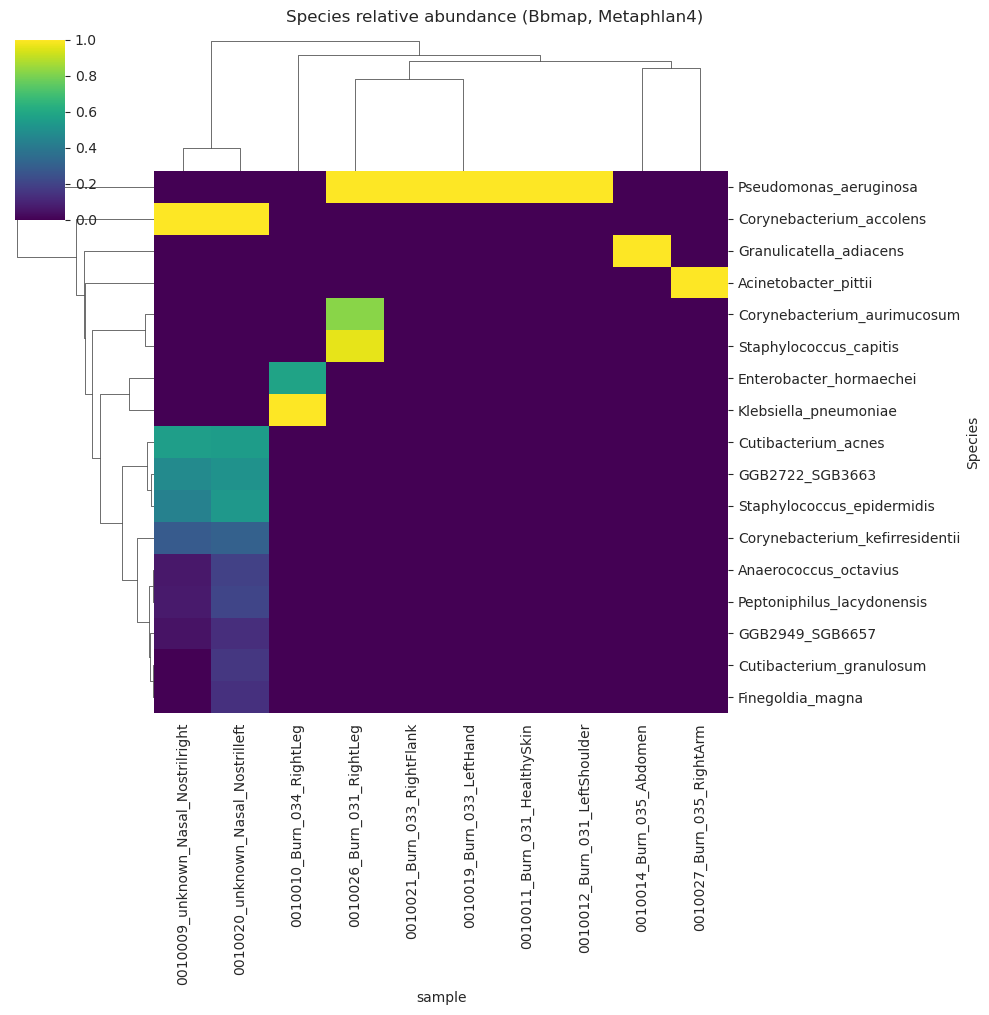

In [31]:
metaphlan4_bbmap_species_plot = plot_relative_abundance(metaphlan_bbmap, 10, "Bbmap, Metaphlan4")
metaphlan4_bbmap_species_plot.savefig('../../results/figures/metaphlan4_bbmap_domains.png', dpi=300, bbox_inches='tight')
metaphlan4_bbmap_species_plot = plot_relative_abundance_bacteria(metaphlan_bbmap, "Species", 10, "Bbmap, Metaphlan4")
metaphlan4_bbmap_species_plot.savefig('../../results/figures/metaphlan4_bbmap_speciess.png', dpi=300, bbox_inches='tight')
metaphlan4_bbmap_species_plot = plot_relative_abundance_bacteria(metaphlan_bbmap,  "Genus", 10, "Bbmap, Metaphlan4")
metaphlan4_bbmap_species_plot.savefig('../../results/figures/metaphlan4_bbmap_genuses.png', dpi=300, bbox_inches='tight')
metaphlan4_bbmap_species_plot = plot_relative_abundance_bacteria(metaphlan_bbmap, "Family", 10, "Bbmap, Metaphlan4")
metaphlan4_bbmap_species_plot.savefig('../../results/figures/metaphlan4_bbmap_families.png', dpi=300, bbox_inches='tight')
metaphlan4_bbmap_cluster_plot = create_clustermap(metaphlan_bbmap, 10, "Bbmap, Metaphlan4")
metaphlan4_bbmap_cluster_plot.savefig('../../results/figures/metaphlan4_bbmap_cluster.png', dpi=300, bbox_inches='tight')

## comparison

In [49]:
merged_df = merged_df.drop_duplicates()

/tmp/ipykernel_1087/427304556.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/427304556.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')
/tmp/ipykernel_1087/427304556.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


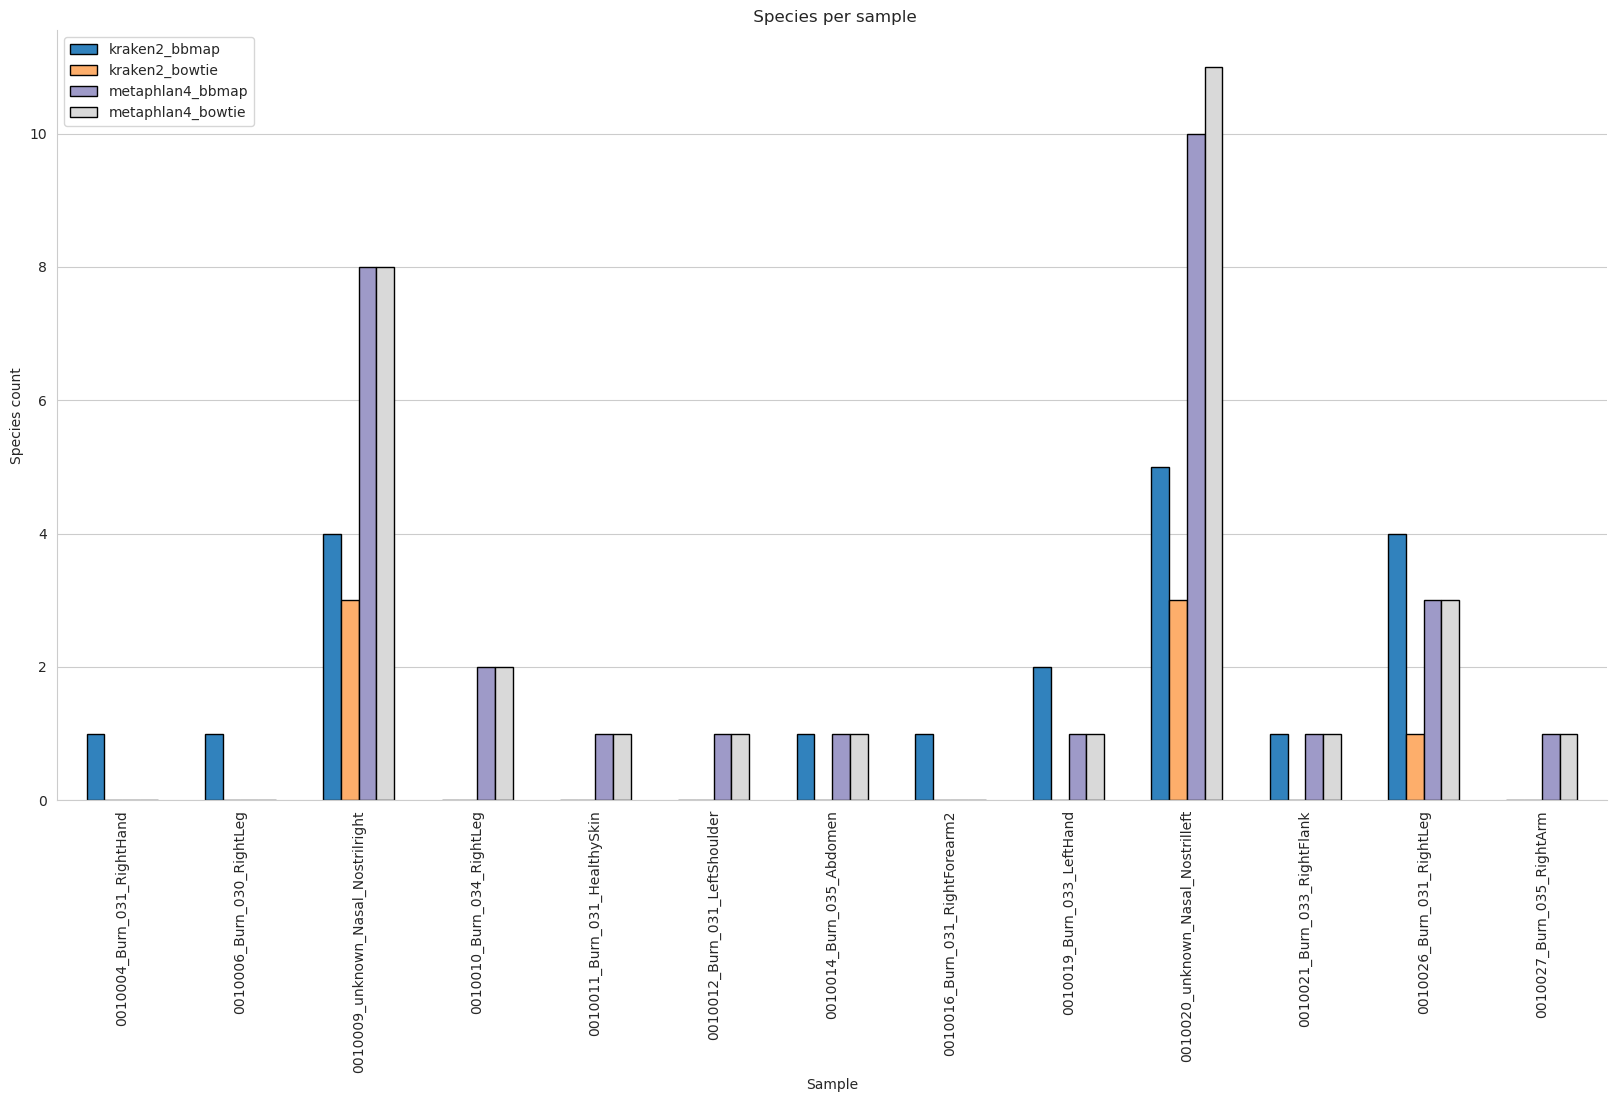

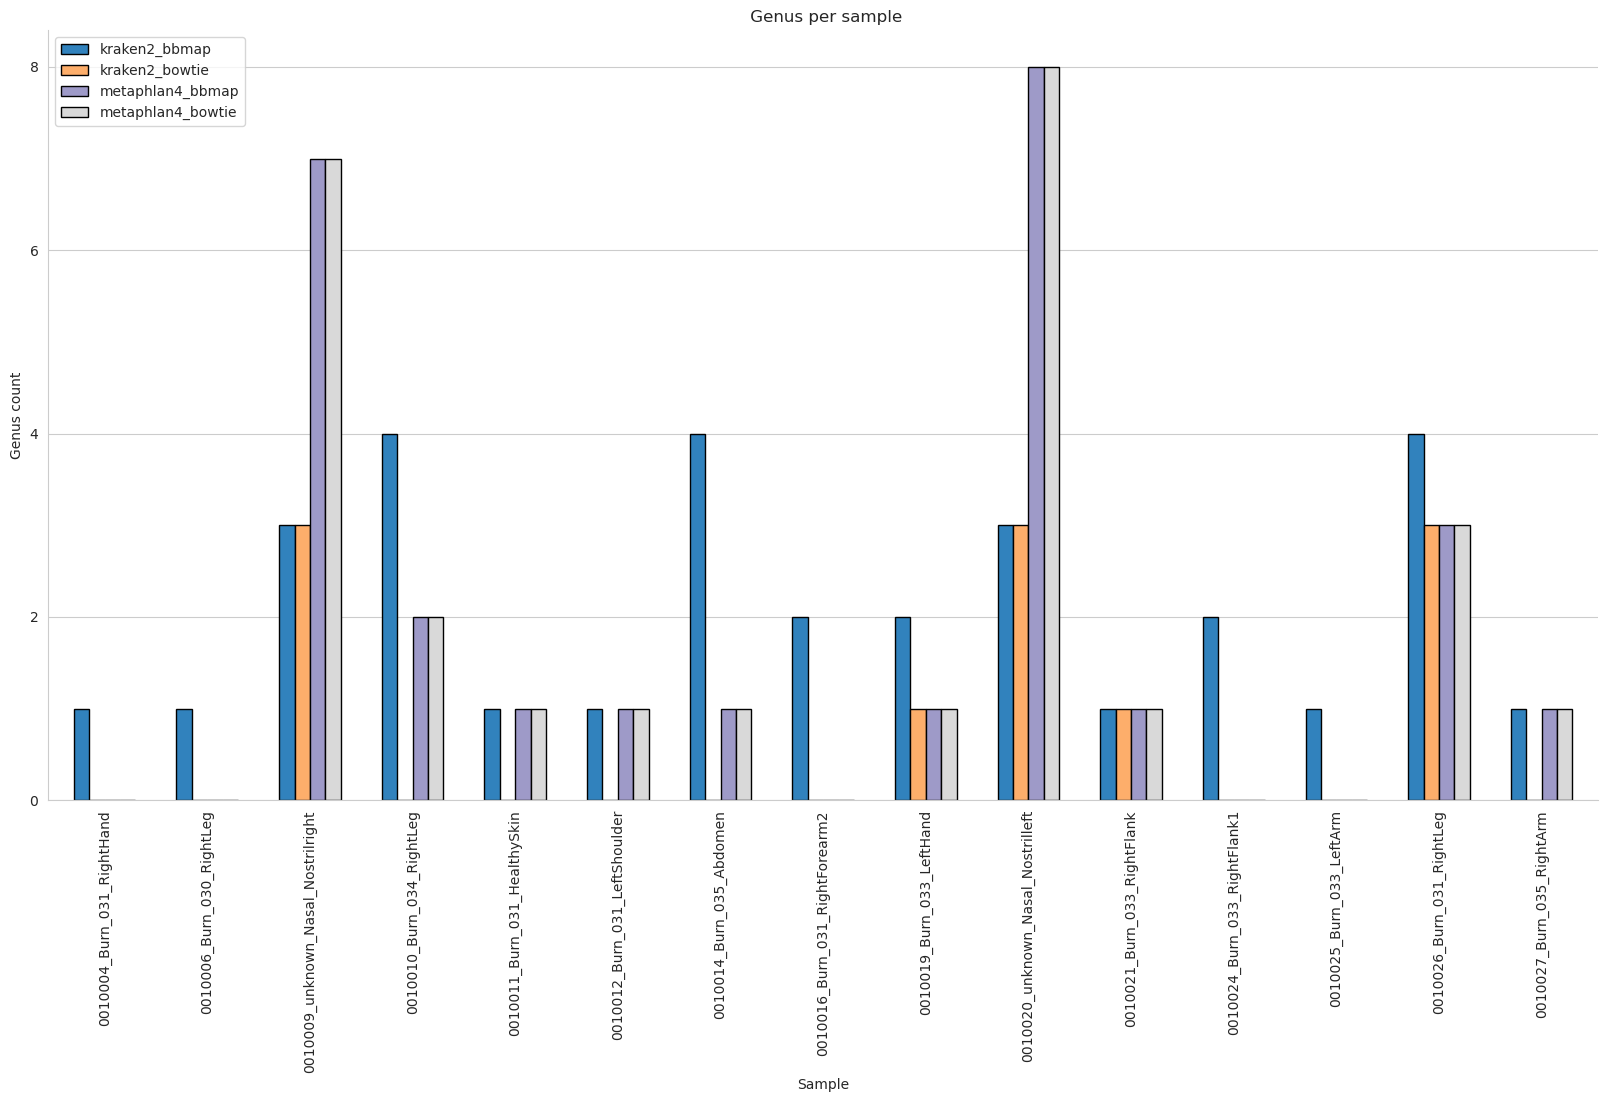

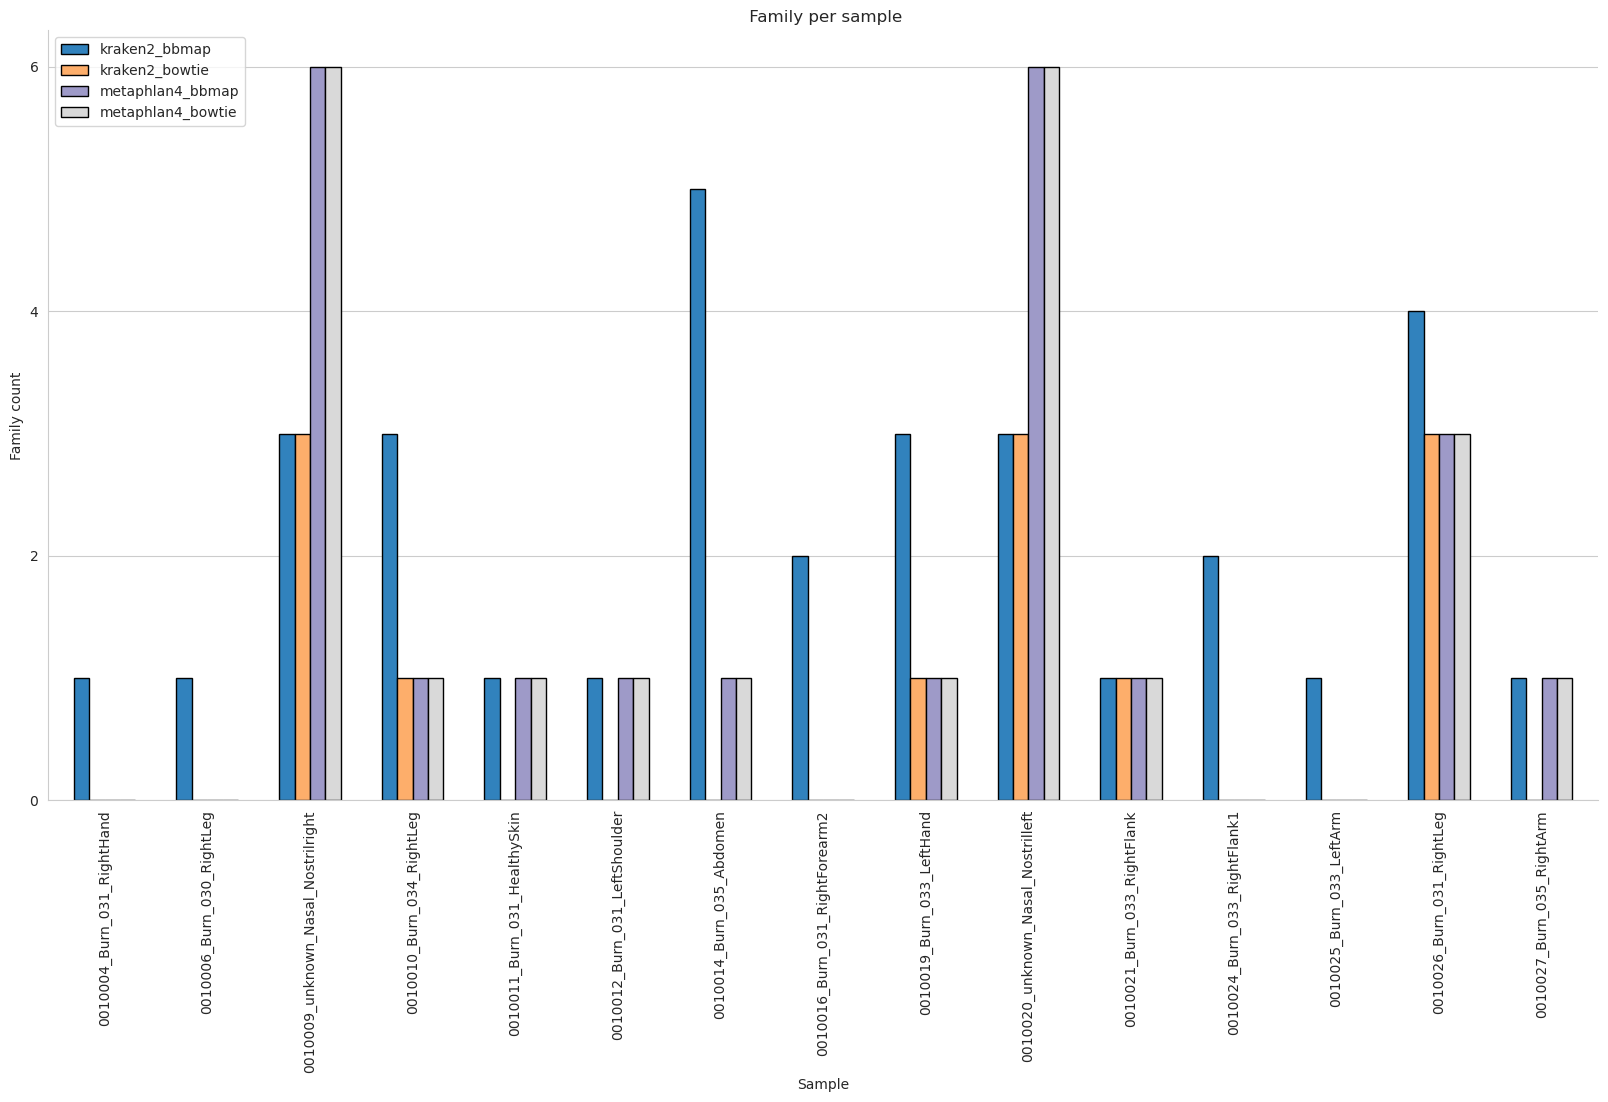

In [50]:
method_comparison_species = method_comparison_bact_taxa(merged_df, "Species", 10)
method_comparison_species.savefig('../../results/figures/method_comparison_species.png', dpi=300, bbox_inches='tight')
method_comparison_genuses = method_comparison_bact_taxa(merged_df, "Genus", 10)
method_comparison_genuses.savefig('../../results/figures/method_comparison_genuses.png', dpi=300, bbox_inches='tight')
method_comparison_families = method_comparison_bact_taxa(merged_df, "Family", 10)
method_comparison_families.savefig('../../results/figures/method_comparison_families.png', dpi=300, bbox_inches='tight')

In [42]:
filtered_metaphlan_bowtie = metaphlan_bowtie[(metaphlan_bowtie["Domain"] == "Bacteria") & (metaphlan_bowtie["relative_abundance"] > 0) & (metaphlan_bowtie["estimated_number_of_reads_from_the_clade"] > 10) & metaphlan_bowtie["Species"].notnull()].reset_index(drop=True)
filtered_metaphlan_bowtie = filtered_metaphlan_bowtie[["Species", "sample"]]

filtered_metaphlan_bbmap = metaphlan_bbmap[(metaphlan_bbmap["Domain"] == "Bacteria") & (metaphlan_bbmap["relative_abundance"] > 0) & (metaphlan_bbmap["estimated_number_of_reads_from_the_clade"] > 10) & metaphlan_bbmap["Species"].notnull()].reset_index(drop=True)
filtered_metaphlan_bbmap = filtered_metaphlan_bbmap[["Species", "sample"]]

filtered_kraken2_bowtie = kraken2_bowtie[(kraken2_bowtie["Domain"] == "Bacteria") & (kraken2_bowtie["relative_abundance"] > 0) & (kraken2_bowtie["estimated_number_of_reads_from_the_clade"] > 10) & kraken2_bowtie["Species"].notnull()].reset_index(drop=True)
filtered_kraken2_bowtie = filtered_kraken2_bowtie[["Species", "sample"]]

filtered_kraken2_bbmap = kraken2_bbmap[(kraken2_bbmap["Domain"] == "Bacteria") & (kraken2_bbmap["relative_abundance"] > 0) & (kraken2_bbmap["estimated_number_of_reads_from_the_clade"] > 10) & kraken2_bbmap["Species"].notnull()].reset_index(drop=True)
filtered_kraken2_bbmap = filtered_kraken2_bbmap[["Species", "sample"]]

filtered_merged_df = filtered_metaphlan_bowtie.merge(filtered_kraken2_bbmap, how='inner')
filtered_merged_df = filtered_merged_df.merge(filtered_metaphlan_bbmap, how='inner')
filtered_merged_df = filtered_merged_df.merge(filtered_kraken2_bowtie, how='inner')
filtered_merged_df = filtered_merged_df.drop_duplicates().reset_index(drop=True)

/tmp/ipykernel_1087/4172402148.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')  # 'viridis' is one of the built-in colormaps


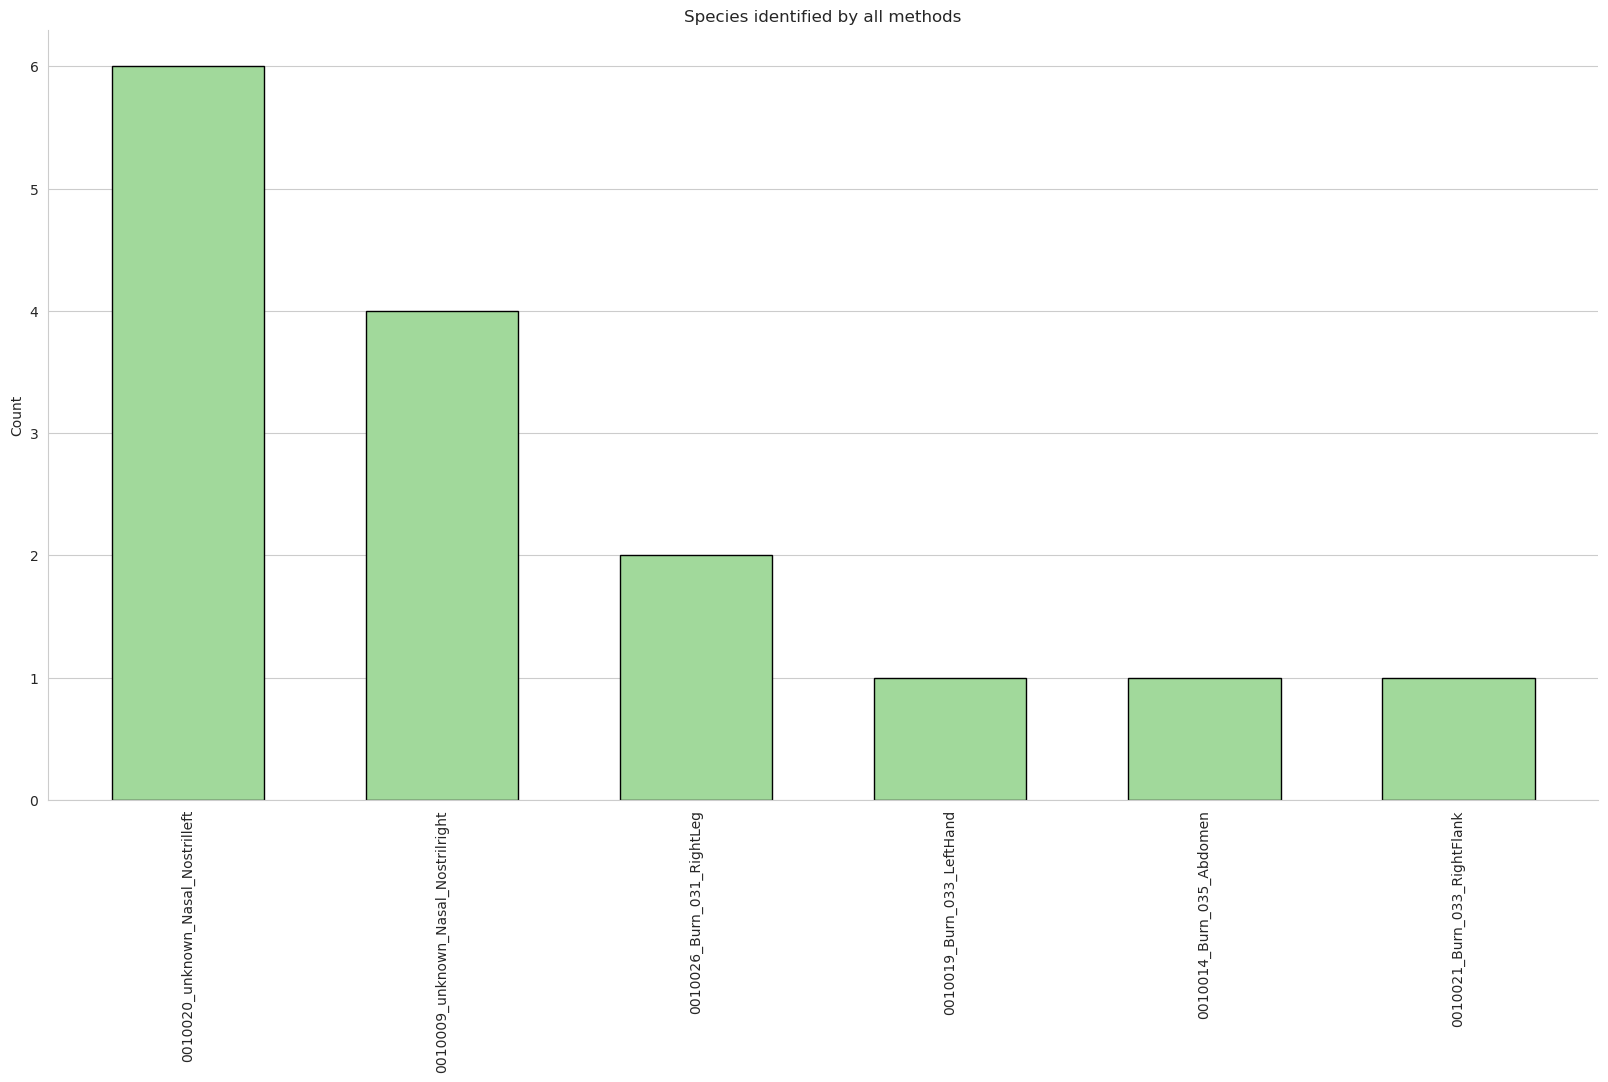

In [43]:
# Count the number of rows for each sample
sample_counts = filtered_merged_df['sample'].value_counts()

# Create a colormap
cmap = cm.get_cmap('tab20c')  # 'viridis' is one of the built-in colormaps

# Select a single color from the colormap
color = cmap(0.5)  # Select the middle color from the colormap

# Create a figure and axis with larger width
fig, ax = plt.subplots(figsize=(20, 10))  # Increase the width of the figure

# Create the bar plot with smaller bar width and specified color
sample_counts.plot(kind='bar', color=color, edgecolor = "black", ax=ax, width=0.6)  # Decrease the width of the bars

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)

# Add more ticks to y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Change the number based on your specific needs

plt.title('Species identified by all methods')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# other

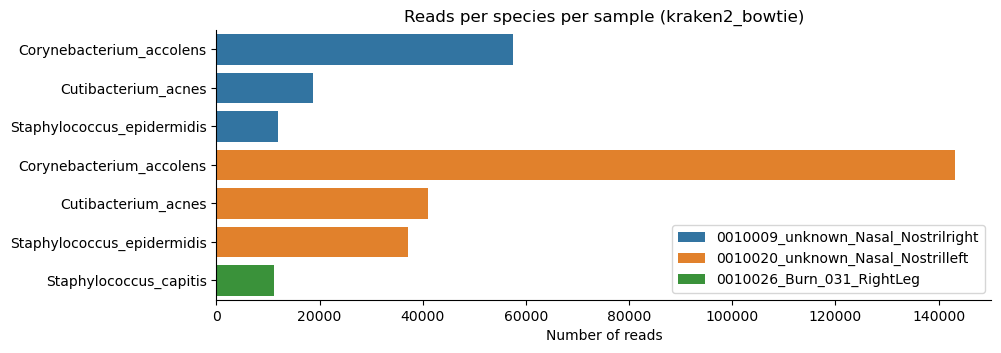

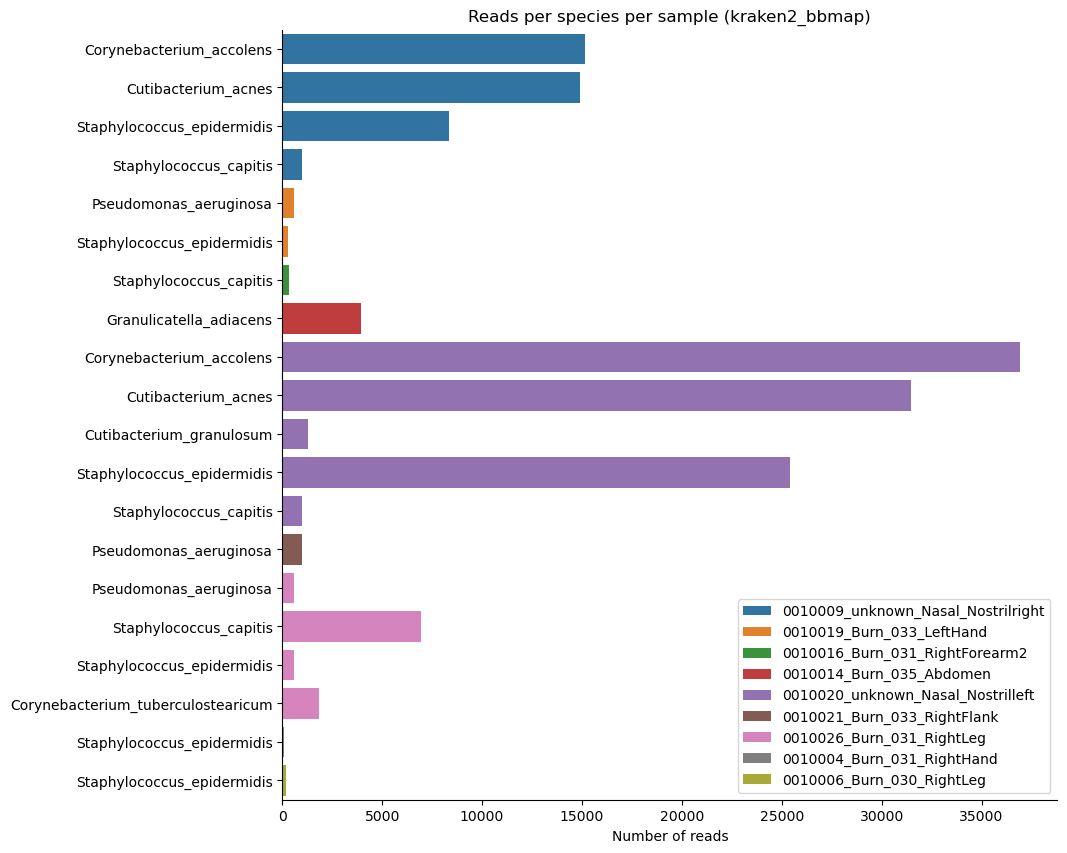

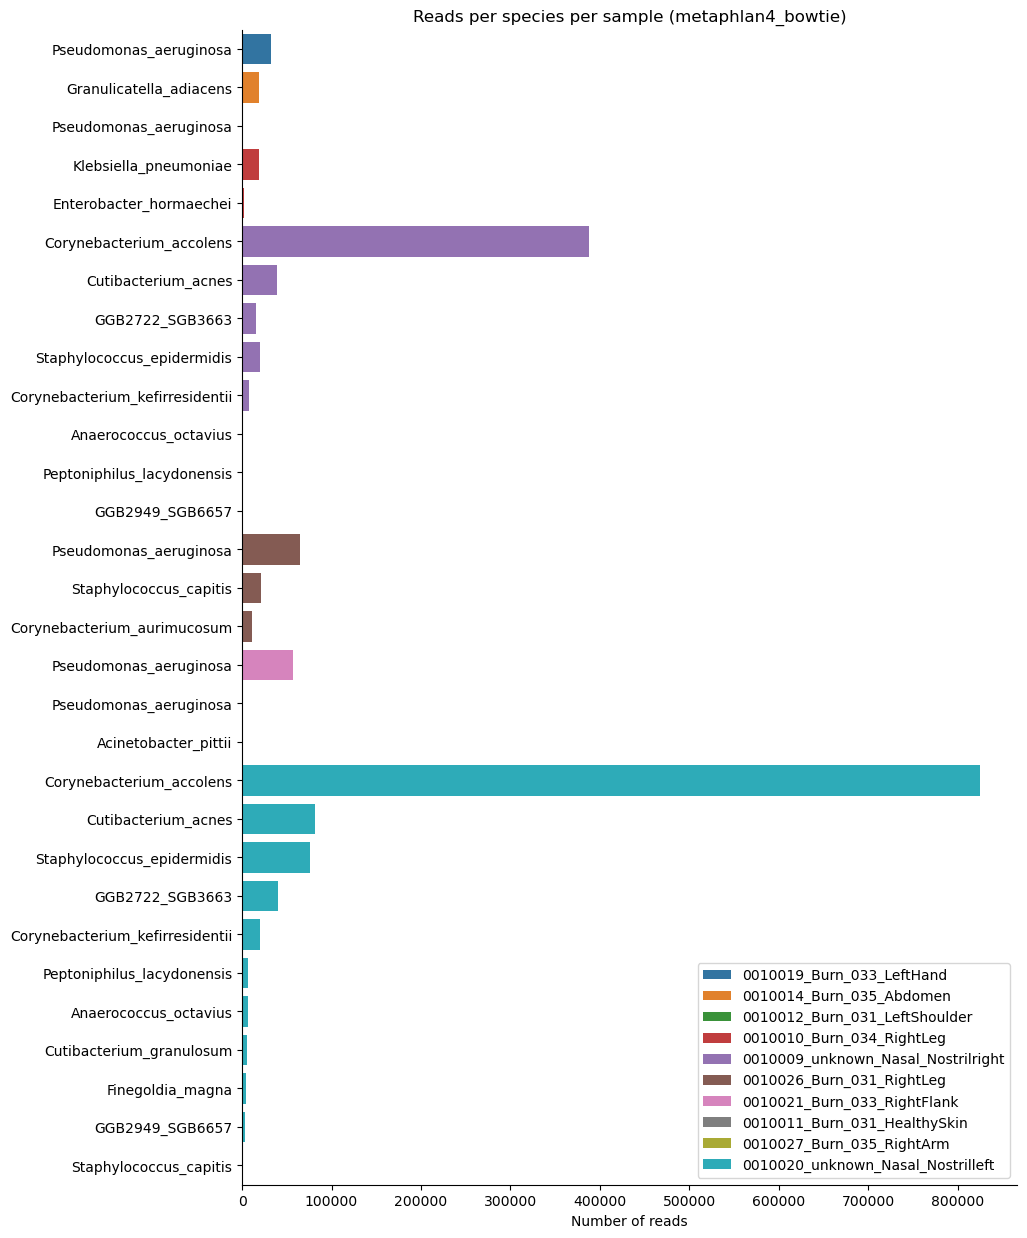

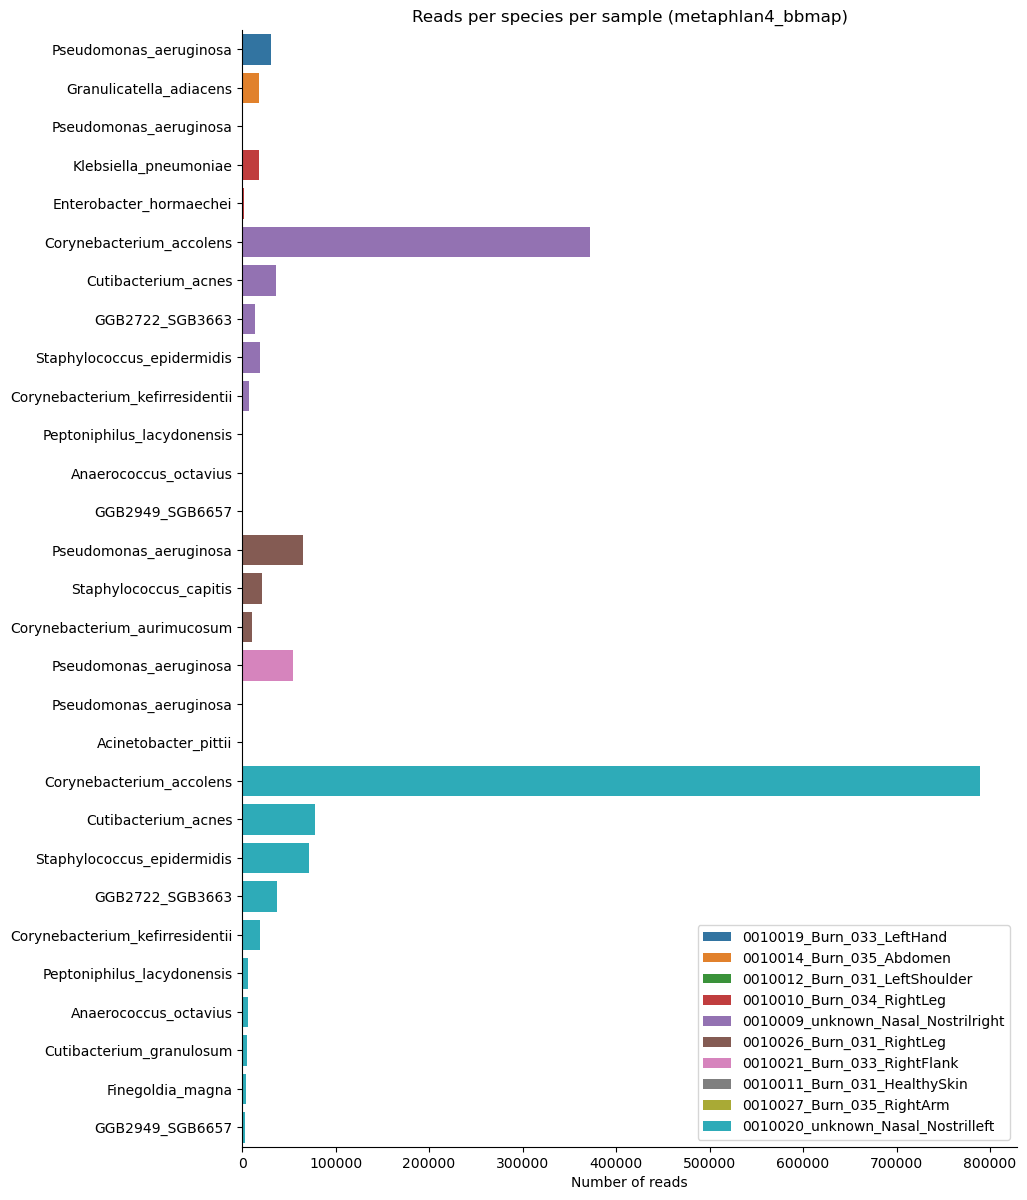

In [72]:
reads_kraken2_bowtie = plot_number_of_reads(kraken2_bowtie, "Species", 10)
reads_kraken2_bbmap = plot_number_of_reads(kraken2_bbmap, "Species", 10)
reads_metaphlan_bowtie = plot_number_of_reads(metaphlan_bowtie, "Species", 10)
reads_metaphlan_bbmap = plot_number_of_reads(metaphlan_bbmap, "Species", 10)

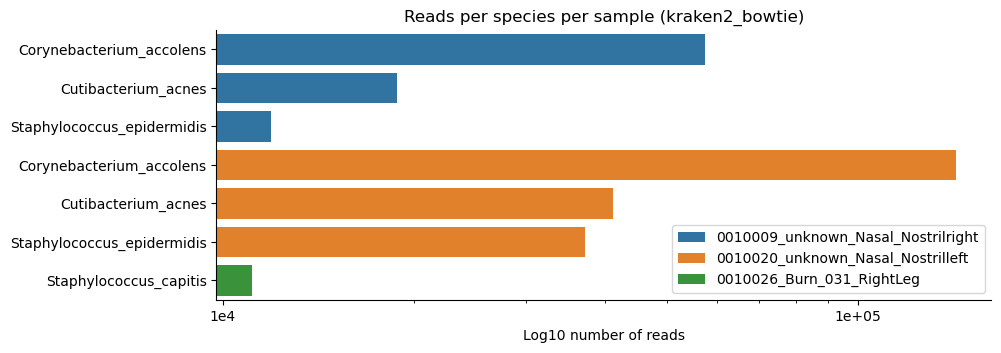

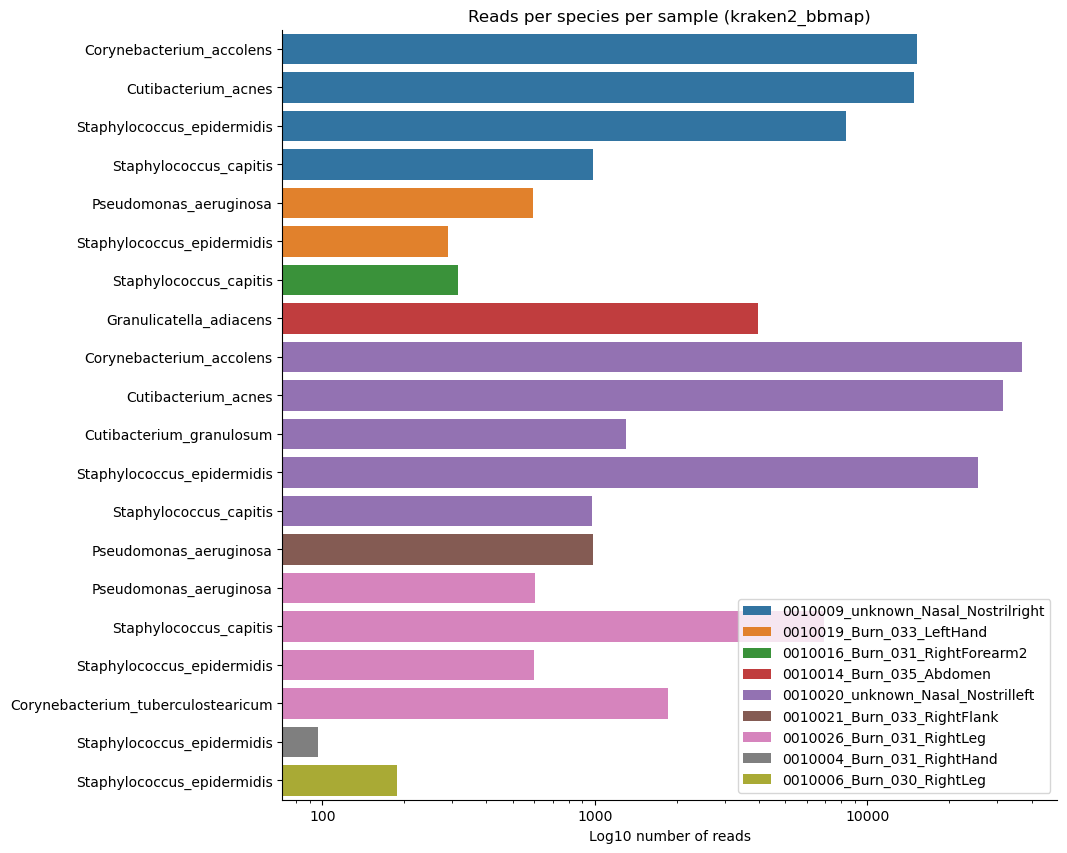

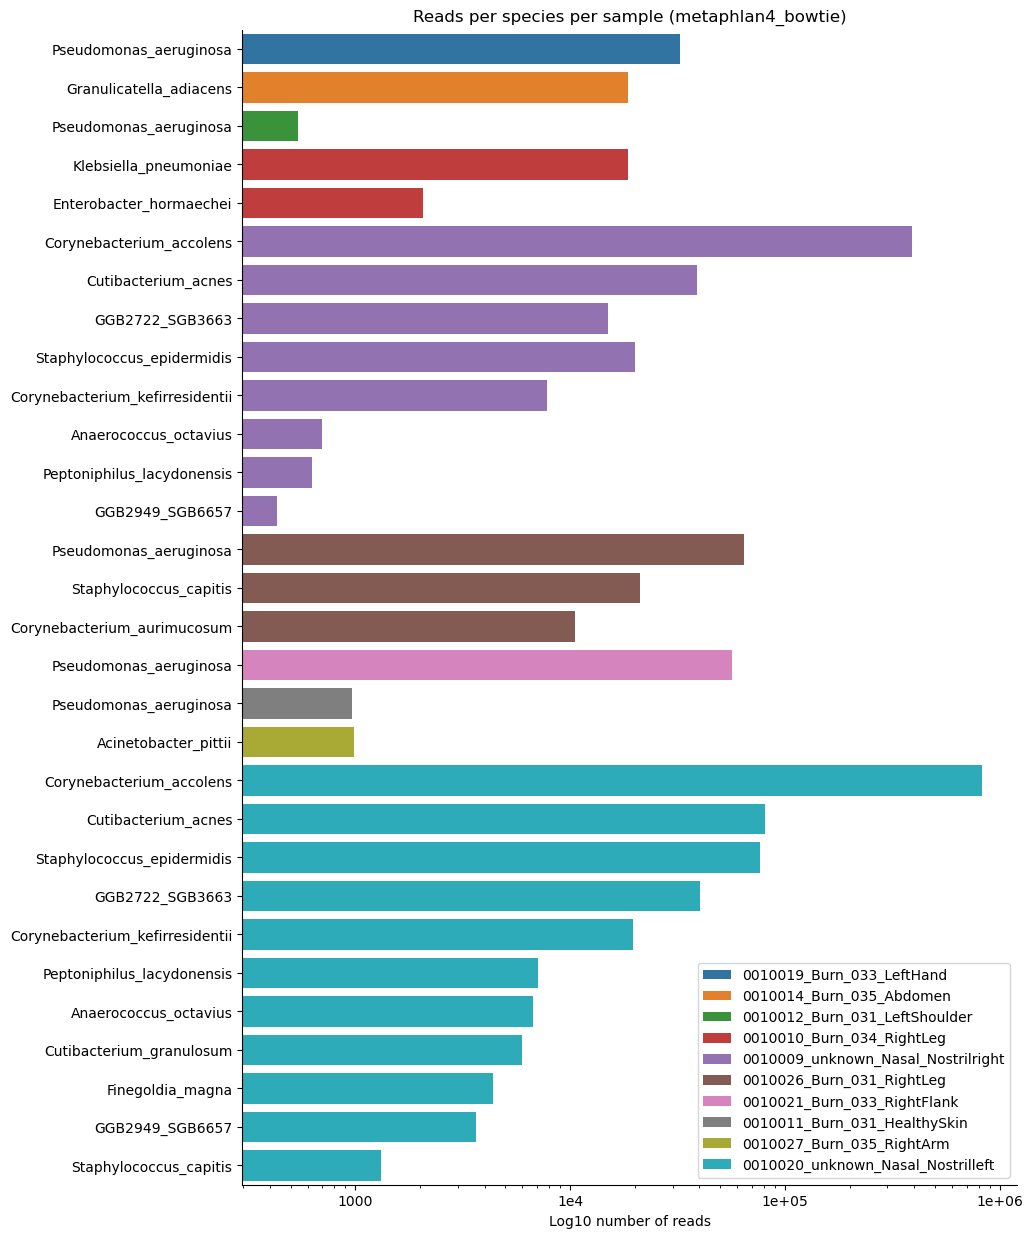

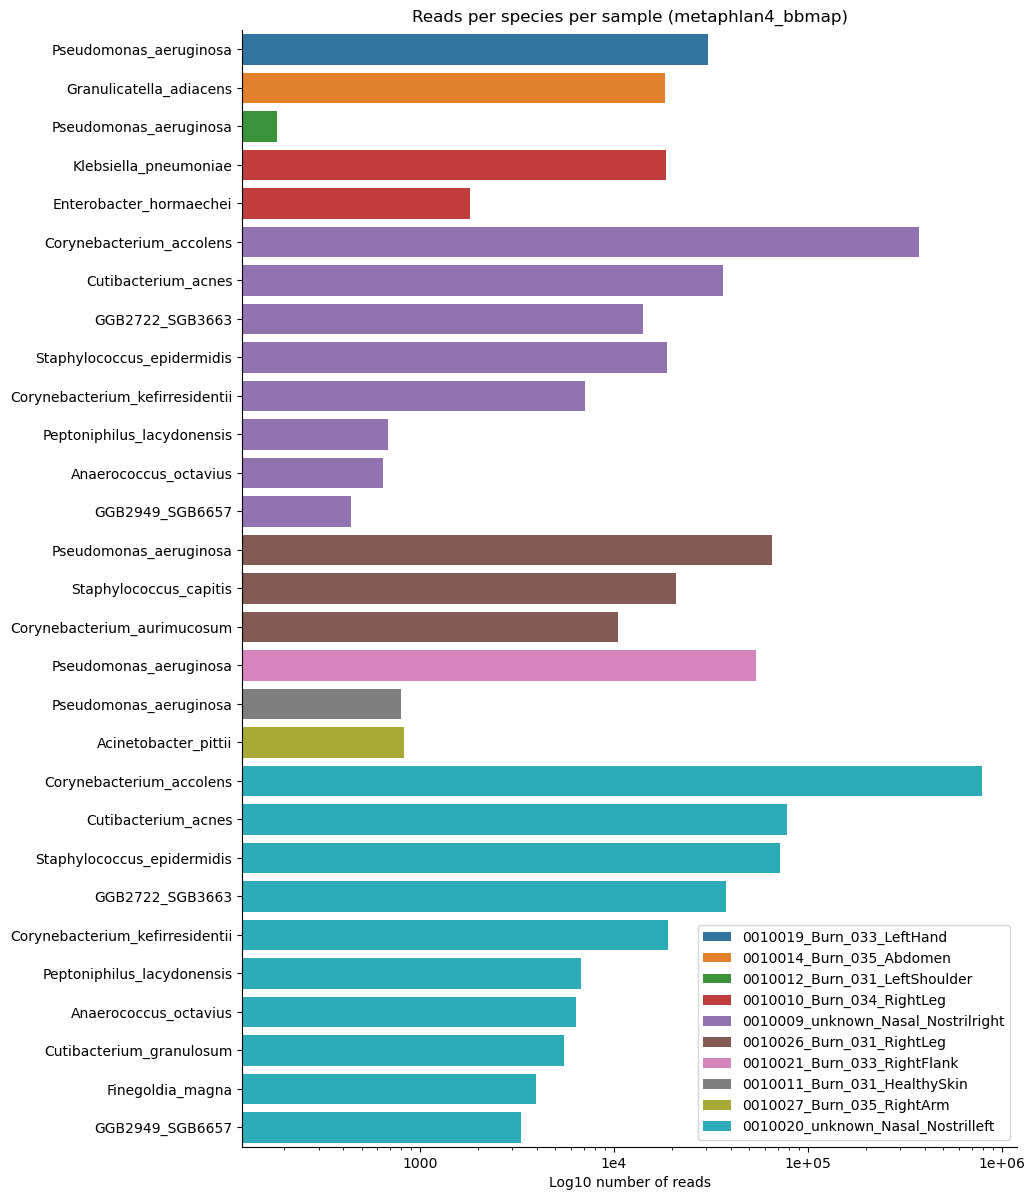

In [70]:
reads_kraken2_bowtie = plot_number_of_reads_log(kraken2_bowtie, "Species", 10)
reads_kraken2_bbmap = plot_number_of_reads_log(kraken2_bbmap, "Species", 10)
reads_metaphlan_bowtie = plot_number_of_reads_log(metaphlan_bowtie, "Species", 10)
reads_metaphlan_bbmap = plot_number_of_reads_log(metaphlan_bbmap, "Species", 10)